<a href="https://colab.research.google.com/github/aymanish/EVAC-Q1-Demand-Forecasting-Model-using-GP/blob/main/EVAC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap

!apt install libgraphviz-dev
!pip install pygraphviz

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns


# **PART 1.1: Algorithm Design:**

To solve this regression problem we chose a Genetic Programming (GP) approach. We chose this approach as GP is a very popular approach to solve Symbolic regression problem by stochastically evolving the function to best fit the regression problem by stitching together a range of mathematical and logical functions in a tree format and applying different parameters on it. This allows us to evolve a regression model using GP but also apply feature selection and transfotmation/engineering as the GP also stochastically chooses the features to be applied on the functions (primitives) within the tree.

This allows us to capture more complex non-liear functions better than using neural networks where it is more complicated and computationally expensive to evolve their weights as well as their topologies which becomes a more complicated approach. GP felt more appropriate.


---
The first step is to decide how to feature engineer and represent our terminal set of leaves in the GP tree. We decided to keep most of the features the same as they were continuous. However, we identified some discrete values such as date and seasons which required preprocessing for regression as the date format and string sused for seasons needed to be converted into numerical format for the mathematical operations of our GP.
Boolean values such as Public holiday and Hire available we also preprocessed.

* Date was converted into 3 seperate columns to represent the Year, Month (1 to 12) and Days of the Week numerically. Days of the Week were further encoded from strings to numbers from 1 to 7. We decided against one hot encoding them as 7 columns since that would create too many features (arguments) for the GP to choose from and thus create a bigger, difficult search space.

* For similar reasons we encoded the booleans, Public holiday and Hire available via binary encoding as 0s and 1s in one column.
* However, we did convert seasons from strings to numbers via one hot encoding since that are purely categorical and encoding them in one column would imply for example one season is bigger than another which makes no sense. To avoid misrepresenting the data we needed independent columns for each of the seasons via one hot encoding. This was alright as there were only 3 seasons so the search space was not expanded too much.


---

X represented all our features and Y representd the regression labels/outputs. We split the data into training and test sets with an 80/20 split. Then we outputted the distribution of the features and outputs across them to ensure the data was evenly split across them and thus avoiding any bias between the test and training test as seen below the following code block. We can see that they are generally equally distributed which is good for reliable testing and evaluation. Overall, we had 17 feaures for our terminal set.

For regression, the GP function to be evolved would be trained on the training set and then evaluated on the test set.

Scaling our values was not seen as a necessity as literature suggests it has no agreed upon benefits.

---



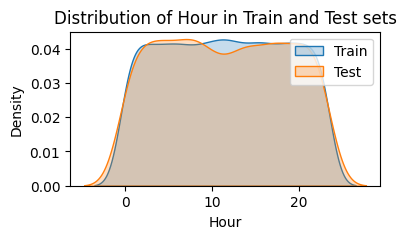

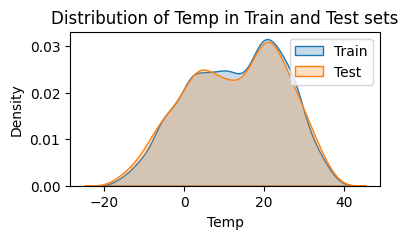

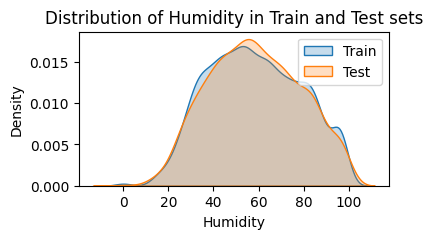

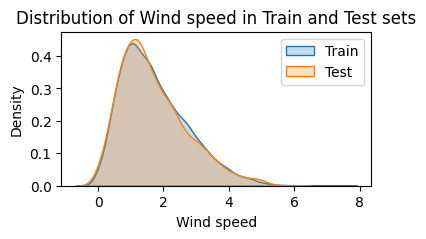

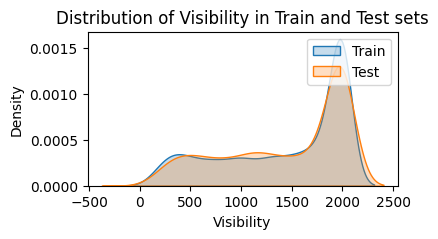

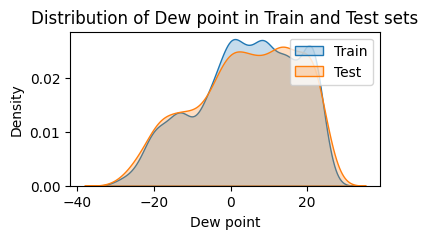

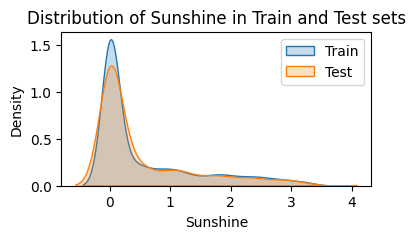

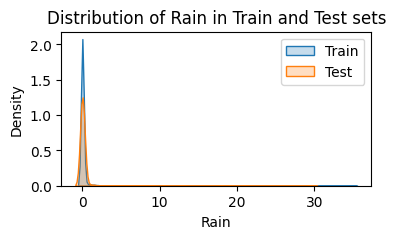

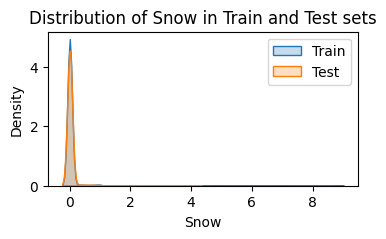

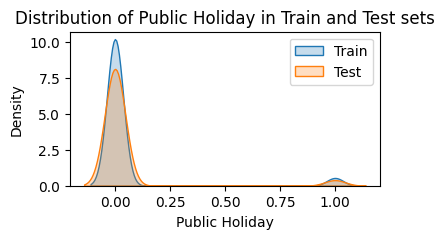

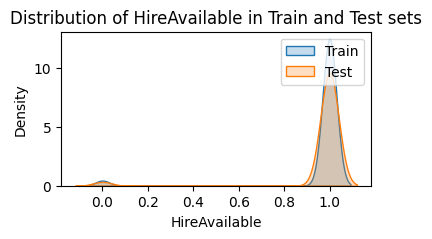

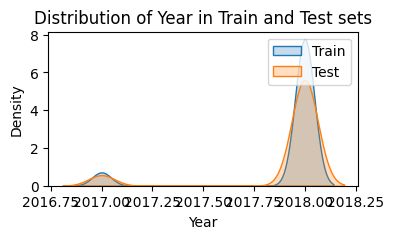

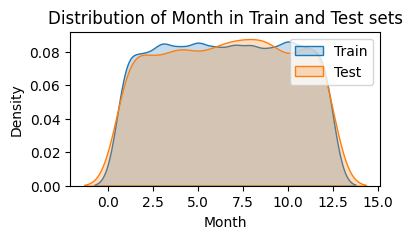

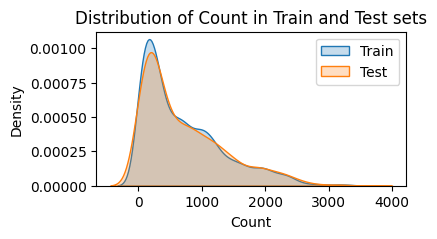

In [ ]:



# File path in Google Drive
file_path = '/content/eScooterDemand.csv'

# Read the CSV file into a dataframe
data = pd.read_csv(file_path)

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Extract year, month, and day of the week (0=Monday, 6=Sunday)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Map the day of the week to 1 (Monday) to 7 (Sunday)
data['DayOfWeek'] = data['DayOfWeek'] + 1

# Encode 'DayOfWeek' using sine and cosine transformations
#data['DayOfWeek_sin'] = np.sin(data['DayOfWeek'] * (2 * np.pi / 7))
#data['DayOfWeek_cos'] = np.cos(data['DayOfWeek'] * (2 * np.pi / 7))

# Strip any extra spaces and convert to lower case for consistent mapping
data['Public Holiday'] = data['Public Holiday'].str.strip().str.lower()
data['HireAvailable'] = data['HireAvailable'].str.strip().str.lower()

# Binary encode 'Public Holiday' and 'HireAvailable'
data['Public Holiday'] = data['Public Holiday'].map({'no': 0, 'yes': 1})
data['HireAvailable'] = data['HireAvailable'].map({'no': 0, 'yes': 1})

# One-hot encode the 'Season' categorical variable
data_encoded = pd.get_dummies(data, columns=['Season'], drop_first=True)

# Convert boolean columns resulting from one-hot encoding to integers (if any)
boolean_columns = data_encoded.select_dtypes(include='bool').columns
data_encoded[boolean_columns] = data_encoded[boolean_columns].astype(int)

# Drop the 'Date' and original 'DayOfWeek' columns as they are no longer needed
#data_encoded = data_encoded.drop(['Date', 'DayOfWeek'], axis=1)
data_encoded = data_encoded.drop(['Date'], axis=1)
# Convert all columns to float
#data_encoded = data_encoded.astype(float)

# Separate features and target
y = data_encoded['Count']
X = data_encoded.drop('Count', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Scale the data by standardizing
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Convert tensors back to DataFrames for plotting
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


# Define a function to plot distributions
def plot_distribution(train, test, feature):
    plt.figure(figsize=(12/3, 6/3))
    sns.kdeplot(train[feature], label='Train', fill=True)
    sns.kdeplot(test[feature], label='Test', fill=True)
    plt.title(f'Distribution of {feature} in Train and Test sets')
    plt.legend()
    plt.show()

# Plot distributions for original features
original_features = ['Hour', 'Temp', 'Humidity', 'Wind speed', 'Visibility', 'Dew point', 'Sunshine', 'Rain', 'Snow', 'Public Holiday', 'HireAvailable', 'Year', 'Month']
for feature in original_features:
    plot_distribution(X_train_df, X_test_df, feature)

# Plot distribution for the target variable
plot_distribution(pd.DataFrame(y_train, columns=['Count']), pd.DataFrame(y_test, columns=['Count']), 'Count')

#X_train = X_train.to_numpy()
#X_test = X_test.to_numpy()

#print(X_train, "\n")
#print(X_test)
#"""


In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

X_train

array([[15. , 13.2, 61. , ...,  0. ,  0. ,  0. ],
       [ 9. , 22.9, 86. , ...,  0. ,  1. ,  0. ],
       [19. , 11.2, 46. , ...,  0. ,  0. ,  0. ],
       ...,
       [14. , 29.5, 62. , ...,  0. ,  1. ,  0. ],
       [20. , -3.4, 51. , ...,  0. ,  0. ,  1. ],
       [22. , 19.3, 55. , ...,  0. ,  0. ,  0. ]])

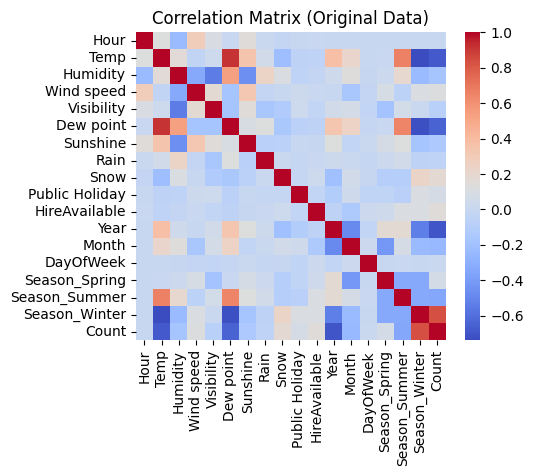

In [ ]:
# Combine features and target for correlation matrix
data_with_target = pd.concat([X, y], axis=1)

# Plot the correlation matrix
plt.figure(figsize=(15/3, 12/3))
sns.heatmap(data_with_target.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (Original Data)')
plt.show()


# **PART 1.1: Algorithm Design**

The second step of GP is to define the set of functions (primitive sset) to use to piece together our evolved program function. For this we chose the simple arithmetic operators such as addition, multiplication, subtraction and division. However, they do not capture any potential non linear relationships which we might potentially have since the correlation matrix of the features in relation to the count do not suggest strong linear relationships, as seen in the correlation matrix in the previous code block.


---

Hence we also included more diverse mathematical functions that would evolve a function that captures more complex non-liear relationships such as using squareroot as well as sinusodial, cosine and tangential functions. We also used an ephemeral constant since there might be constant scalars in our regression function.

Since GP can lead to very large Y/output values very quickly due to the random nature and since it might lead to operations that might create mathematicla errors, we defined a protected_operation() decorator to act as a wrapper function on all the functions used in the primitive set defined above. This wrapper essentially flagged any errors and returned zero so as not to influence or interrupt our GP evolution in any way. This included errors such as Zero division,Value errors and runtime errors. Hence, if we tried to devide by zero that would not stop our evolution training.

---


We also considered including exponential and logarithmic functions but after some quick initial testing, realised they led to too many infinite output/count values (Y) due to the nature of those operators creating large values too quickly leading to memory and processing issues even when using protected versions of them.

Due to worries of making the evolved model too redundantly complex we opted against using these 2 operators. Crucialy though, the primitive set of functions could approximately achieve the effects of these functions anyway. If we can obtain a solution function that uses these simpler functions that would also be easier to explain.

They thus provided a good balanced approach to start with.

In [ ]:
import operator
import math
import random
import pygraphviz as pgv
from deap import gp, base, creator, tools, algorithms
import functools

# Define a primitive set for the GP
print(X_train.shape[1])
pset = gp.PrimitiveSet("MAIN", X_train.shape[1])  # Number of features after encoding = 18



def protected_operation(func):
    @functools.wraps(func)
    def protected_func(*args, **kwargs):
        with np.errstate(all='ignore'):
            try:
                result = func(*args, **kwargs)
                if np.isinf(result) or np.isnan(result):
                    #print(f"Invalid result encountered: {result} in {func.__name__}")
                    return 0
                return result
            except (ValueError, ZeroDivisionError, OverflowError, RuntimeError, RuntimeWarning) as e:
                #print(f"Exception encountered: {e} in {func.__name__}")
                return 0
    return protected_func

# Apply decorator to functions
protected_add = protected_operation(operator.add)
protected_sub = protected_operation(operator.sub)
protected_mul = protected_operation(operator.mul)
protected_div = protected_operation(operator.truediv)
protected_sqrt = protected_operation(math.sqrt)
#protected_exp = protected_operation(math.exp)
protected_sin = protected_operation(math.sin)
protected_cos = protected_operation(math.cos)
protected_tan = protected_operation(math.tan)
#protected_log = protected_operation(math.log)

pset.addPrimitive(protected_add, 2)
pset.addPrimitive(protected_sub, 2)
pset.addPrimitive(protected_mul, 2)
pset.addPrimitive(protected_div, 2)
pset.addPrimitive(protected_sqrt, 1)
#pset.addPrimitive(protected_exp, 1)
pset.addPrimitive(protected_sin, 1)
pset.addPrimitive(protected_cos, 1)
pset.addPrimitive(protected_tan, 1)
#pset.addPrimitive(protected_log, 1)

# Add ephemeral constants
pset.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1))

# Rename arguments to be more readable
for i in range(X_train.shape[1]):
    pset.renameArguments(**{f"ARG{i}": f"x{i}"})


# **Part 1.1: Algorithm Design**

Evolutionary algorithms such as GP always have a fitness function to evaluate the individuals (our tree functions) that are evolved. FOr our case, as is common for regression problems we use the regularised L2 function also known as the mean square error of the prediction output of the training featues Xtrain by our evolved individual against the actual outputs y_train.

Hence, the MSE calculates the overall distance between the actual outputs and our predictor functions outputs but squared. The smaller this value the smaller the distance and the closer our predictions are to the actual output. This by treating the GP fitness as the fitness to minimise we can evolve better solutions that get closer and closer to prediction function that models the output well. Since it squares these distances, our GP is more sensitive to and penalises poorer solutions (larger fitensses are exagerated) thus encouraging our evolution to progress faster.

In [ ]:
def eval_gp_individual(individual, X_train, y_train): #new
    # Transform the tree expression into a callable function
    func = toolbox.compile(expr=individual)

    # Apply the function to the training data
    predictions = np.array([func(*row) for row in X_train])
    #print(predictions)

    # Calculate mean squared error
    mse = ((predictions - y_train) ** 2).mean()
    return mse,




# **Part 1.1: Algorithm Design**

With all of these things defined we can now design our individuals and the necessary components for our GP:

* We use the DEAP library to create a fitness. The weight is set to negative one to treat this as a minimisation problem since the lower the MSE the better the inidividual evolved.

* We represented our individual as a tree structure with the leaves of the tree containing a subset/selection of X features from our terminal set. These are applied to the functions from our defined primitive set which act as the nodes and branches of our tree based individual.

A population would contain a number of such trees to be evolved.


---

We also selected appropriate genetic operators to evolve our GP trees / functions:

* We firs tneed to consider to how generate the initial population of trrees, particularly their structure. The full method uses a predefined height that is maintained across all tree solutions for all trees throughout the population. The terminals (features selected) are also only applied in the final depth. This significantly limits the search space and diversity of our tree solutions. Also might create unnecessarily long trees from the start.

 The grow method, random trees are generated across a minimum and maximum height by iteratively selecting nodes from the terminals or functions. Branches have different depths.

 We chose the Half and half method that has the best of both worlds where half the time generation is done via grow and half the time it is done via full. This provdes a wider array of solutions that either grow or full by itself.

 To allow for a high level of granilarity in tree creation we chose the minimum and maximum tree height to be between 1 and 2. This also ensured we did not bloat our tree by generating big trees too quickly but starting small and slowly generate trees by adding small chunks of trees as we evolve better and better solutions.



---

* For the selection of fit individuals to move on to the next generation we choose to use the double tournament selection. This is a variation of the tournament selector that selects individuals based on fitness proportion: individuals who are more fit have a higher probaility of being selected but still gives a small chances for less fit individuals that could evolve into better solutions later to also be potentially selected. This ensures diversity across generations and avoids evolving towards a lcoal minima.

 Double tournament however does another set of tournaments by evaluating the bloat of the individuals (the size of the tree by both depth and width). As solutions evolve, we might evolve good solutions that might become bloated and contain alot of redundant functions and makes our soluton unexplainable.

 To counter this we use a parsimony size which applies parisomony pressure to our individuals during selection. By increasing the parsimony pressure from 1 to 2 be make our selector more stingy or ungenerous. At 1 it prioritises only based on fitness but as it increases the probability of selecting an individual with smaller size is prefered over the fitness score. For the start we have kept this at 50/50 by setting the parsimony size to 1.5. THe tournament size (fitness size) it kept to a default of 5, giving each individual a chance to fight.



---

* For mutation and crossover operators we chose to keep things relatively simple to start with by using the built in Uniform mutations and one point crossover functions. Uniform mutation randomly selects a point in the tree individual and replaces the subtree at that point with a newly randomly generated tree. This tree is generated via the 'expr_mut' tool which creates a half and half tree that could be between 0 and 2 in size. Again, this ensures a granular steady aproach to mutation without making too big a change.

* For crossover we use one point crossover which randomly selected a crossover point from 2 parent individuals and exchanges the subtree between each individual.

We also applied a static depth limit to our mutator and crossover operator to prevent the height of our trees from getting too big beyond a depth of 10. This complements the persimony pressure in bloat control. Regression models can get quite complex so 10 was used as an above average starting point.

In [ ]:
# Define the fitness type and create the individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", eval_gp_individual, X_train=X_train, y_train=y_train)
#toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("select", tools.selDoubleTournament, fitness_size = 5, parsimony_size = 1.5, fitness_first = True, fit_attr='fitness' )
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2) #2
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10)) # can i get similar results with less depth




stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)




In [ ]:
pip install scikit-posthocs

# **Part 1.1: Algorithm Design**

We use the built in eaSimple which applies the basic evolutionary loop  by initialising a population, selects the offsprings and randomly selects offspring parents by fitness to apply crossover with a propability of cxpb to ensure good genes are copied over to the next generation. It then applies mutation to crossover offsprings randomly based on the probability mutpb.

We now have a pool of individuals that are evolved and iterate to the next generation where we repeat the process of selecting the best individuals using the selector which selects a new population of the same population size.

This repeats the eovlution untill we reach the target number of generations. We also use the Hall fo fame to keep track of the best individual evovled throughout the whole process thus introducing a level of elitism, although most of the survivor selection is a generational strategy as is common for GPs.


---



# **Part *1.3*: Investigation of parameters and representation:**

With the GP algorithm and representation designed and implemented we now need to understand the effect and optimize the parameters and the representation of our tree individuals inorder to improve our solution. The primary metric of improvement is the fitness function: The MSE.

But we also look at the standard deviation and median fitness of our soutions thus ensuring diversity. Particularly, we are looking at the the mean best fitness (MBF) across the multiple runs for given set of parameters and representation. The best fitness is the min fitness at the final generation. We are putting less emphasis on the average fitness as our GP is being accessed for producing the best possible solution for our regression problem. The MBF ensures we are obtaining it to some level of consistency.

As bloat is another issue, we also investigate the effect on of parameter and representation on the size of our solution.


---
As mentioned certain parameters and representational choices we kept constant such as the min and max height of our half and half tree generator for both initialization and mutation, the choice of mutation and crossover and the static depth limit of our tree heights. While they were justified they also generally do not have difficult to expect or make big changes to our minimum fitness and size and can be tested further if needed later.

Instead, we chose to focus on 3 main things:
* **The combination of different probabilities of crossver (cxpb) and mutation (mutpb):** Instead of simply trying out a range of probabilities for crossover or mutation probabilities independently while keeping hte other constant which does not tell us much, we ran a grid test of the combination of the 2. This allows us to see how their combined interplay affects fitness and size.

* **The range of the parsimony sizes for our double tournament: ** Instead of varying the height through our static limits the overall bloat via the size (which includes both height and width) is more important. The parsimony size parameter controls this as mentioned. So we want to understand its effect on size and the fitness.

* The range of population sizes to initialise our GP: We want to see the effect of varying the population size on the diversity, fitness and size of our results.


---




# **PART 1.3 / 1.4: Investigation and evaluation of crossover and mutation combinations**

We tested the combinations of various ranges of mutation and crossover values. For mutation we used the range:
* mutpb = [0.05, 0.2, 0.8]

This has a good range of very low mutation at 5% to moderate at 20% and high mutation at 80%.

Crossover ranges were as follows:
* cxpb = [0.2, 0.5, 0.8]

This also has a good range of low to moderate to high crossover. Overall we obtain 9 combinations of crossover and mutation rate pairs.

We ran our tests for 10 runs across random seeds to ensure reproducibility for each combination of cxpb and mutpb. Since this is exploratory investigation we did not choose large populations or generations due to the delay. Instead for this test the rest of the parameters were constant at:

* runs = 10, generations = 20, population size = 50

Loza's classic book on GP [1] advices users to set mutation rate at 0 or 5% at best, suggesting that GP works wiithout mutation or moreso suggests that in GP crossover acts as a form of macro mutation. Other works by Banzhaf et al [2] recommend 5% mutation rate. This is heavily opinionated, under a shared view that crossover has a large shuffling effect acting in some way as a macromutator. However, opinions are divided on this and so we test for combiantions of mutation and corssover at different magnitudes.

The logbook resutls of the were stored in a dictionary for statistical analysis. The raw results of the best individual per run (since we are mainly evaluating the best solution) are tested for significance.


In [ ]:
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

# Define the GP components (primitives, toolbox, etc.)

# Function to perform multiple runs and collect logbooks
def multiple_runs_cxmut(toolbox, n_runs, cxpb, mutpb, ngen, pop_size):
    all_logbooks = []
    for run in range(n_runs):
        random.seed(run)  # Set the random seed for reproducibility
        np.random.seed(run)
        population = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        size_stats = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats, size=size_stats)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "nevals"] + mstats.fields

        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            ngen=ngen, stats=mstats, halloffame=hof, verbose=True
        )
        all_logbooks.append(logbook)
    return all_logbooks, all_logbooks


# Define the grid search parameters
n_runs = 10#10
ngen = 20
pop_size = 50
cxpb_range =  [0.2, 0.5, 0.8]
mutpb_range = [0.05, 0.2, 0.8]

# Perform grid search
grid_search_results = {}

for cxpb in cxpb_range:
    for mutpb in mutpb_range:
        key = f"cxpb_{cxpb}_mutpb_{mutpb}"
        print(f"cxpb_{cxpb}_mutpb_{mutpb}")
        grid_search_results[key], all_logbooks = multiple_runs_cxmut(toolbox, n_runs, cxpb, mutpb, ngen, pop_size)

#all_logbooks = multiple_runs(toolbox, n_runs, cxpb, mutpb, ngen, pop_size)

In [ ]:
# Create new dictionaries to store the statistics as lists for each combination
stats_dicts = {}

for key, logbooks in grid_search_results.items():
    # Initialize dictionary to hold lists for each statistic
    stats_dicts[key] = {
        "avg_fitness": [],
        "min_fitness": [],
        "max_fitness": [],
        "std_fitness": [],
        "avg_size": [],
        "min_size": [],
        "max_size": [],
        "std_size": []
    }

    for logbook in logbooks:
        # Extract statistics from the last generation
        stats_dicts[key]["avg_fitness"].append(logbook.chapters["fitness"].select("avg")[-1])
        stats_dicts[key]["min_fitness"].append(logbook.chapters["fitness"].select("min")[-1])
        stats_dicts[key]["max_fitness"].append(logbook.chapters["fitness"].select("max")[-1])
        stats_dicts[key]["std_fitness"].append(logbook.chapters["fitness"].select("std")[-1])
        stats_dicts[key]["avg_size"].append(logbook.chapters["size"].select("avg")[-1])
        stats_dicts[key]["min_size"].append(logbook.chapters["size"].select("min")[-1])
        stats_dicts[key]["max_size"].append(logbook.chapters["size"].select("max")[-1])
        stats_dicts[key]["std_size"].append(logbook.chapters["size"].select("std")[-1])

# Print the number of runs for each combination and each stat for verification
for key, stats in stats_dicts.items():
    print(f"{key} statistics:")
    for stat, values in stats.items():
        print(f"{stat} ({len(values)} runs): {values}")
    print("\n")




---


We did a comprehensive analysis on all available stats for the best individual at the end of each generation across the 10 runs for each combination of cxpb and mutpb combination.

The stats we investigated were:
* avgerage fitness
* minimum fitness (used to evaluate the mean best fitness)
* standard deviation of fitness
* average size (the size of our individuals)

Since we only had 10 runs and cannot assume the data is normally distributed we combined each stat across all the 9 combinations to perform Kruskal Wallis test as we have more than 2 groups (9). We've set our statistical significance score p value to 0.05. We then perform post hoc Dunns test to see whether there are any statistical significance across the 9 combinations. This statistical test pipeline is applied to all further statistical test across the study.

We first look at the p values for minimum fitness below.

In [ ]:
# Import necessary libraries for statistical tests
from scipy.stats import kruskal
import scikit_posthocs as sp
def perform_statistical_tests(stats_dicts, stat_type='avg_fitness'):
    """
    Perform Kruskal-Wallis test and Dunn's post hoc test on the specified statistic type.

    Parameters:
    - stats_dicts (dict): Dictionary containing the statistics for each combination.
    - stat_type (str): The type of statistic to analyze (e.g., 'avg_fitness', 'min_fitness').

    Returns:
    - kruskal_result: The result of the Kruskal-Wallis test.
    - dunn_results: The result of Dunn's post hoc test.
    """
    # Extract the specified stat_type values for all combinations
    stat_values = []
    labels = []
    for key, stats in stats_dicts.items():
        stat_values.append(stats[stat_type])
        labels.extend([key] * len(stats[stat_type]))

    # Perform Kruskal-Wallis test on the specified stat_type values
    kruskal_result = kruskal(*stat_values)
    print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")

    # Interpret the Kruskal-Wallis test result
    if kruskal_result.pvalue < 0.05:
        print("There are statistically significant differences between the groups.")
    else:
        print("There are no statistically significant differences between the groups.")

    # Prepare data for Dunn's test
    data = pd.DataFrame({
        stat_type: [item for sublist in stat_values for item in sublist],
        'group': labels
    })

    # Perform Dunn's test for post hoc analysis
    dunn_results = sp.posthoc_dunn(data, val_col=stat_type, group_col='group', p_adjust='bonferroni')
    print(dunn_results)

    return kruskal_result, dunn_results

# Example usage
kruskal_result_min_fitness, dunn_results_min_fitness = perform_statistical_tests(stats_dicts, stat_type='min_fitness')
#MIN FITNESS
print(kruskal_result_min_fitness)
print(dunn_results_min_fitness)

Kruskal-Wallis H-statistic: 12.595767064895657, p-value: 0.12653563349617294
There are no statistically significant differences between the groups.
                     cxpb_0.2_mutpb_0.05  cxpb_0.2_mutpb_0.2  \
cxpb_0.2_mutpb_0.05             1.000000                 1.0   
cxpb_0.2_mutpb_0.2              1.000000                 1.0   
cxpb_0.2_mutpb_0.8              1.000000                 1.0   
cxpb_0.5_mutpb_0.05             1.000000                 1.0   
cxpb_0.5_mutpb_0.2              1.000000                 1.0   
cxpb_0.5_mutpb_0.8              1.000000                 1.0   
cxpb_0.8_mutpb_0.05             1.000000                 1.0   
cxpb_0.8_mutpb_0.2              0.696876                 1.0   
cxpb_0.8_mutpb_0.8              1.000000                 1.0   

                     cxpb_0.2_mutpb_0.8  cxpb_0.5_mutpb_0.05  \
cxpb_0.2_mutpb_0.05                 1.0             1.000000   
cxpb_0.2_mutpb_0.2                  1.0             1.000000   
cxpb_0.2_mutpb_0.8 



---
The results above show a Kruskal-Wallis H-statistic: 12.59 and p-value: 0.12. As p value is over 0.05 this suggest that there are no statistically significant differences between the groups.

Delving a bit deeper, the Dunns test does show some variations in the statistical significance across our combinations, although not enough to be statistically significant. The same was observed in the average fitness, standard deviation of the fitnesses and the average size of individuals in the stats below.

While there are variations in the performance across our combinations they dont seem to suggest statistical significance. This could be due to the excessive stochatic nature of genetic programming meaning we might need to do more tests and runs but we had time and resource constraints. Since we are doing exploratory investigation it might also be a case of increasing the desired p value score from 0.05.

Overall, these set of results are consistent with literature suggesting that the proportion of crossover to mutation and its effect on the performance of GP is still inconclusive. While many academics suggest a high crosssover and low mutation at 80% to 20% split this is heavily debated as we cannot say with certainly that crossover is only a macromutation or something more sophisticated that preserves good solutions for GP.

While our resutls were inconclusive we can still look at the box plot and mean distributions of the statistics to understand some suggested trends in conjunction with the variation of the p values above and below.

In [ ]:
def perform_statistical_tests(stats_dicts, stat_type='avg_fitness'):
    """
    Perform Kruskal-Wallis test and Dunn's post hoc test on the specified statistic type.

    Parameters:
    - stats_dicts (dict): Dictionary containing the statistics for each combination.
    - stat_type (str): The type of statistic to analyze (e.g., 'avg_fitness', 'min_fitness').

    Returns:
    - kruskal_result: The result of the Kruskal-Wallis test.
    - dunn_results: The result of Dunn's post hoc test.
    """
    # Extract the specified stat_type values for all combinations
    stat_values = []
    labels = []
    for key, stats in stats_dicts.items():
        stat_values.append(stats[stat_type])
        labels.extend([key] * len(stats[stat_type]))

    # Perform Kruskal-Wallis test on the specified stat_type values
    kruskal_result = kruskal(*stat_values)
    print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic}, p-value: {kruskal_result.pvalue}")

    # Interpret the Kruskal-Wallis test result
    if kruskal_result.pvalue < 0.05:
        print("There are statistically significant differences between the groups.")
    else:
        print("There are no statistically significant differences between the groups.")

    # Prepare data for Dunn's test
    data = pd.DataFrame({
        stat_type: [item for sublist in stat_values for item in sublist],
        'group': labels
    })

    # Perform Dunn's test for post hoc analysis
    dunn_results = sp.posthoc_dunn(data, val_col=stat_type, group_col='group', p_adjust='bonferroni')
    print(dunn_results)

    return kruskal_result, dunn_results


kruskal_result_avg_fitness, dunn_results_avg_fitness = perform_statistical_tests(stats_dicts, stat_type='avg_fitness')
#AVERAGE FITNESS
print(kruskal_result_avg_fitness)
print(dunn_results_avg_fitness)

Kruskal-Wallis H-statistic: 13.953992673992673, p-value: 0.08297248957034088
There are no statistically significant differences between the groups.
                     cxpb_0.2_mutpb_0.05  cxpb_0.2_mutpb_0.2  \
cxpb_0.2_mutpb_0.05             1.000000                 1.0   
cxpb_0.2_mutpb_0.2              1.000000                 1.0   
cxpb_0.2_mutpb_0.8              0.309492                 1.0   
cxpb_0.5_mutpb_0.05             1.000000                 1.0   
cxpb_0.5_mutpb_0.2              0.030368                 1.0   
cxpb_0.5_mutpb_0.8              1.000000                 1.0   
cxpb_0.8_mutpb_0.05             0.733156                 1.0   
cxpb_0.8_mutpb_0.2              0.542336                 1.0   
cxpb_0.8_mutpb_0.8              1.000000                 1.0   

                     cxpb_0.2_mutpb_0.8  cxpb_0.5_mutpb_0.05  \
cxpb_0.2_mutpb_0.05            0.309492                  1.0   
cxpb_0.2_mutpb_0.2             1.000000                  1.0   
cxpb_0.2_mutpb_0.8 

In [ ]:
# STD FITNESS (STANDARD DEVIATION)
kruskal_result_std_fitness, dunn_results_std_fitness = perform_statistical_tests(stats_dicts, stat_type='std_fitness')

print(kruskal_result_std_fitness)
print(dunn_results_std_fitness)

Kruskal-Wallis H-statistic: 14.652307692307659, p-value: 0.0662693116862311
There are no statistically significant differences between the groups.
                     cxpb_0.2_mutpb_0.05  cxpb_0.2_mutpb_0.2  \
cxpb_0.2_mutpb_0.05             1.000000                 1.0   
cxpb_0.2_mutpb_0.2              1.000000                 1.0   
cxpb_0.2_mutpb_0.8              0.110217                 1.0   
cxpb_0.5_mutpb_0.05             1.000000                 1.0   
cxpb_0.5_mutpb_0.2              0.055465                 1.0   
cxpb_0.5_mutpb_0.8              1.000000                 1.0   
cxpb_0.8_mutpb_0.05             1.000000                 1.0   
cxpb_0.8_mutpb_0.2              0.294265                 1.0   
cxpb_0.8_mutpb_0.8              1.000000                 1.0   

                     cxpb_0.2_mutpb_0.8  cxpb_0.5_mutpb_0.05  \
cxpb_0.2_mutpb_0.05            0.110217                  1.0   
cxpb_0.2_mutpb_0.2             1.000000                  1.0   
cxpb_0.2_mutpb_0.8  

In [ ]:
# AVERAGE SIZE OF INDIVIDUALS
kruskal_result_avg_size, dunn_results_avg_size = perform_statistical_tests(stats_dicts, stat_type='avg_size')

print(kruskal_result_avg_size)
print(dunn_results_avg_size)

Kruskal-Wallis H-statistic: 10.200522231923673, p-value: 0.25123307066997025
There are no statistically significant differences between the groups.
                     cxpb_0.2_mutpb_0.05  cxpb_0.2_mutpb_0.2  \
cxpb_0.2_mutpb_0.05                  1.0                 1.0   
cxpb_0.2_mutpb_0.2                   1.0                 1.0   
cxpb_0.2_mutpb_0.8                   1.0                 1.0   
cxpb_0.5_mutpb_0.05                  1.0                 1.0   
cxpb_0.5_mutpb_0.2                   1.0                 1.0   
cxpb_0.5_mutpb_0.8                   1.0                 1.0   
cxpb_0.8_mutpb_0.05                  1.0                 1.0   
cxpb_0.8_mutpb_0.2                   1.0                 1.0   
cxpb_0.8_mutpb_0.8                   1.0                 1.0   

                     cxpb_0.2_mutpb_0.8  cxpb_0.5_mutpb_0.05  \
cxpb_0.2_mutpb_0.05                 1.0                  1.0   
cxpb_0.2_mutpb_0.2                  1.0                  1.0   
cxpb_0.2_mutpb_0.8 



---

Since we were unable to get conclusive investigation from the tests above we plot the box plots for the stats of all 9 combinations of cxpb and mutpb below:

Based on them we can make some claims on their effect on our GP solution and algorithm:

* Firstly, crossover rate variation had little effect overall and instead mutation rates showed more interesting effects on our solutions.

* Based on the Box plot for min_fitness for mutation rates 0.05: we can reasonably infer that at low mutation rates the mean best fitness is consistently the highest when the mutation rate is low at 0.05 out of the 3 mutations (0.05, 0.2, 0.8) for a given crossover rate. Additionally mut 0.05 at cxpb of 0.5 and 0.8, also has a lower standard deviation as seen by the range of the box plots for those 2 combinations. This leads to some suggestion that mowlutation rates do not promote diversity in our soltions early on and that we might be stuck at a local minima around a fitness MSE of 700,000.

* A similar case could be made for mut 0.05 as per box plot for avg_size and box plot for std_size which shows that the average sizes for our best individuals are stuck at low avrage sizes with very little variation and distribution. Furhter suggest that low mutations might not evolve larger trees that might be better and instead are stuck at simpler, smaller sized trees. This makes sense with our small size for the mutated tree that are added per mutation in our steady building approach.

---

Moving on, the 2 combinations that performed reasonably well were cx/mut = 0.5/0.2 and cx/mut = 0.8/0.2.
* Firstly, they had more variation in their fitnesses suggesting more diversity. This can be inferred from box plot for avg_fitness and box_plot for std_fitness. The statistical tests from above also support this with the p-value of 0.03 for cx/mut (0.5/0.2) and cx.mut(0.2/0.05) for their average fitnesses, suggesting they are statistically different. The combination of 0.8/0.2 had a higher degree of this but that might not be desirable and 0.5/0.2 might be better for convergence towards better solutions overall.

* They also show the lowest mean best fitness scores (MBF) through their means in the box plot for min_fitness. Both achieve a mean min fitness of around 500,000 and a greatly reduced lowest fitness of around 300,000. They are the only 2 combinations to do so.

* Additionally, as per the box plots for std_size, their standard deviation for the sizes are in a middle ground which is desired over the lower diverse sizes at mut 0.05 that are prone to stuck on local minima potentially. Similarly, at 0.8 mutations the deviation of sizes is also the greatest across the 3 sets of combinations.

Hence, combinations 0.5/0.2 (cx/mut) and 0.8/0.2 (cx/mut) potentially provide us with the best parameters for our GP algorithm. We can see that we have ended up reasoning for a higher crossover to mutation ratio anyway despite no statistical significance, as is the popular method for GP.

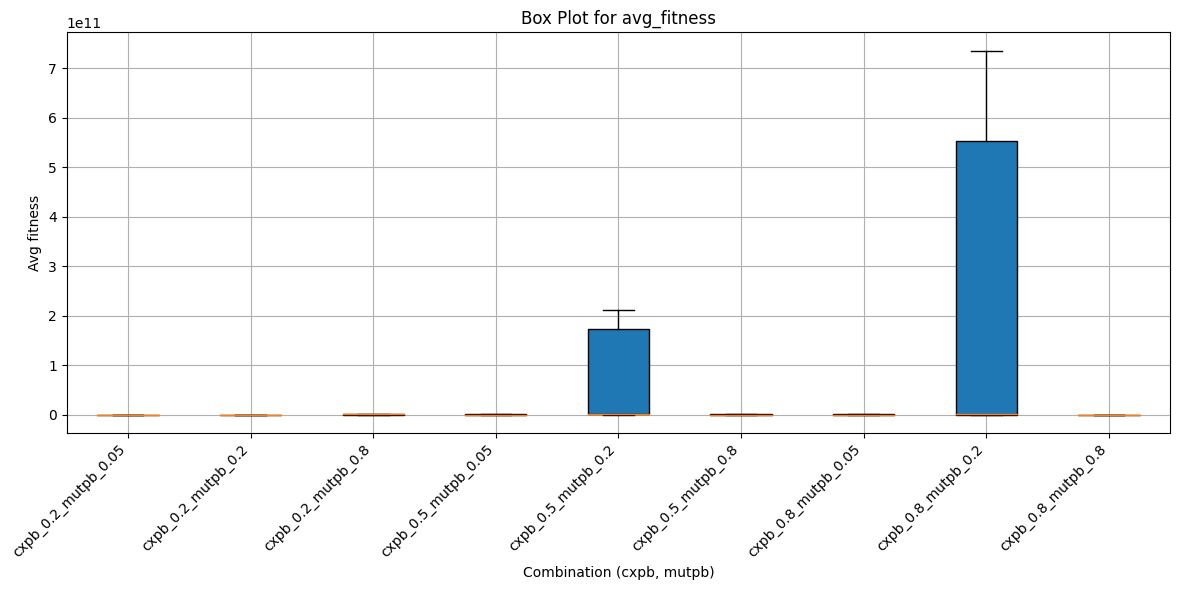

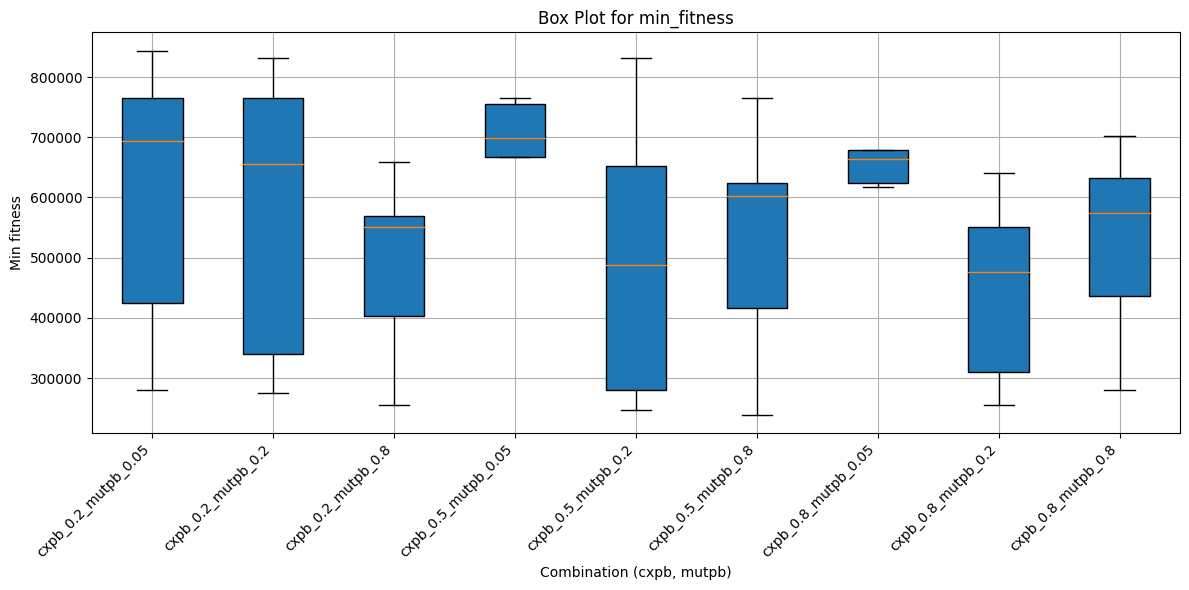

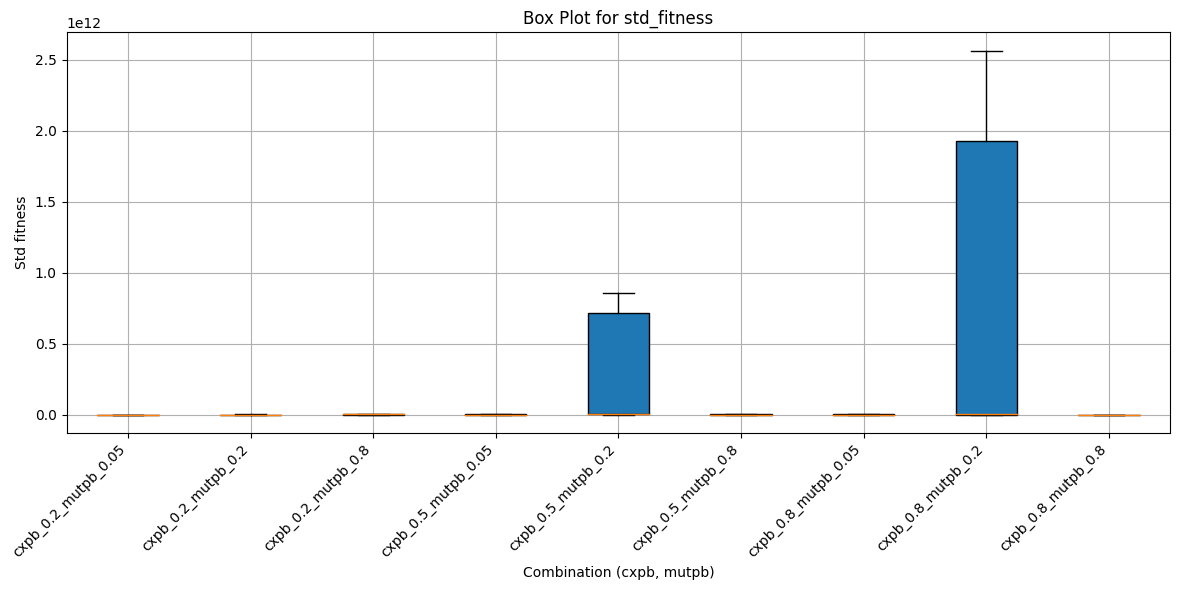

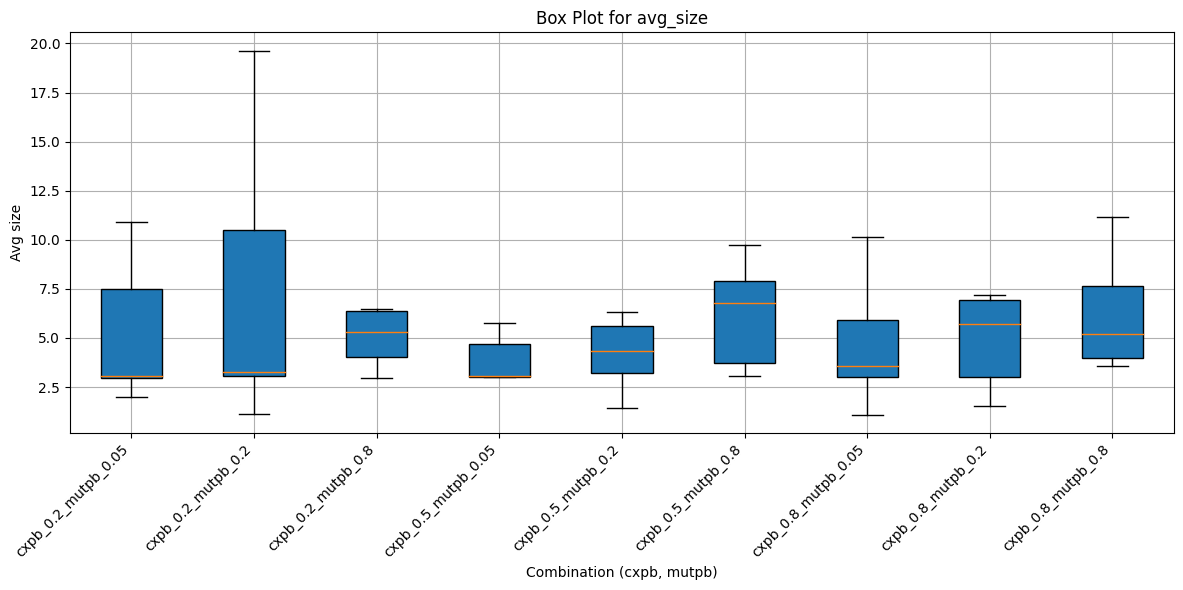

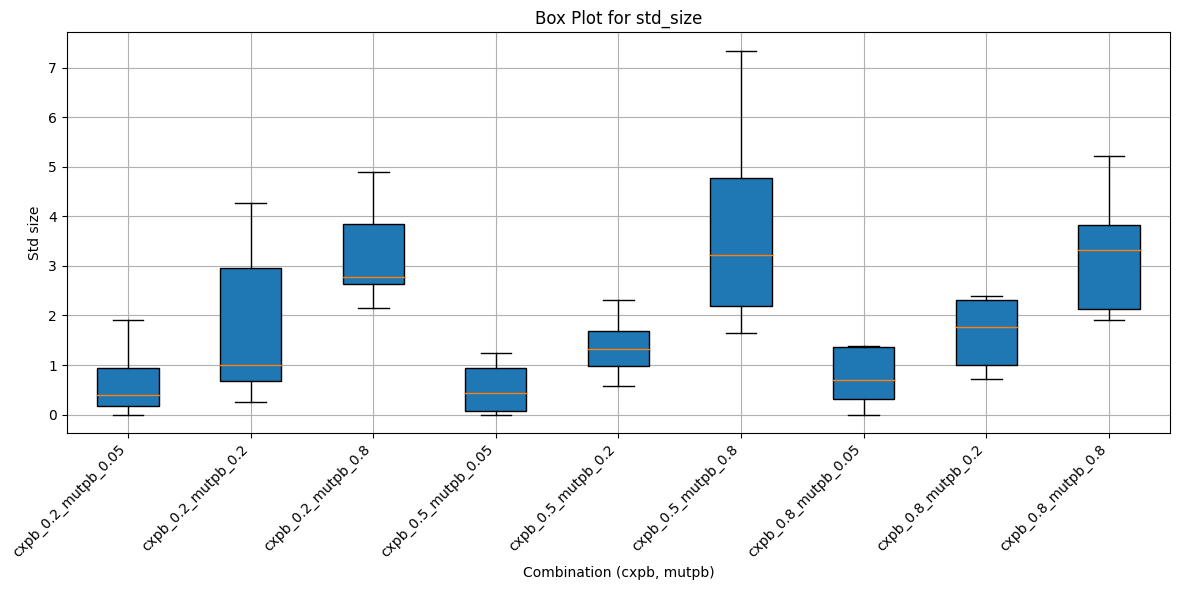

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplot_for_stat(stats_dicts, stat_type='avg_fitness'):
    """
    Plot box plots for the specified statistic type for all combinations.

    Parameters:
    - stats_dicts (dict): Dictionary containing the statistics for each combination.
    - stat_type (str): The type of statistic to plot (e.g., 'avg_fitness', 'min_fitness').
    """
    # Extract the specified stat_type values for all combinations
    stat_values = []
    labels = []
    for key, stats in stats_dicts.items():
        stat_values.append(stats[stat_type])
        labels.append(key)

    # Create a box plot
    plt.figure(figsize=(12, 6))
    plt.boxplot(stat_values, labels=labels, patch_artist=True, showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Box Plot for {stat_type}')
    plt.xlabel('Combination (cxpb, mutpb)')
    plt.ylabel(stat_type.replace('_', ' ').capitalize())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_boxplot_for_stat(stats_dicts, stat_type='avg_fitness')
plot_boxplot_for_stat(stats_dicts, stat_type='min_fitness')
plot_boxplot_for_stat(stats_dicts, stat_type='std_fitness')

plot_boxplot_for_stat(stats_dicts, stat_type='avg_size')
plot_boxplot_for_stat(stats_dicts, stat_type='std_size')


The trends mentioned above can also be visualised in the min_fitness and average size over generation plots for the 9 combinations below. These represent the average behavious of each combination across the 10 runs:
* Statistics for cxpb 0.2 mutpb 0.05, cxpb 0.5 mutpb 0.05 and cxpb 0.8 and mutpb 0.05 plots also show their respective average minimum fitness trend lines spending most of the generations stuck at a local minima, indicated by the plateaud and horizontal blue lines.

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e55390340> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


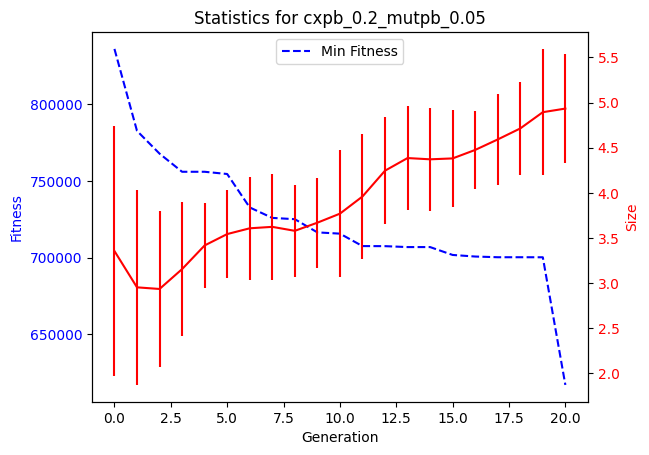

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e56e68f10> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


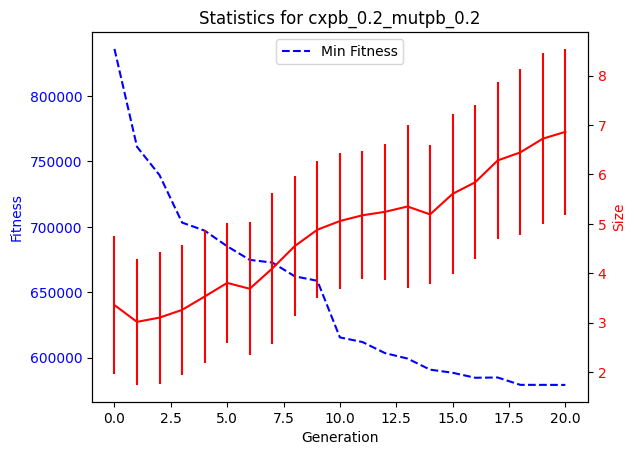

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e58801d80> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


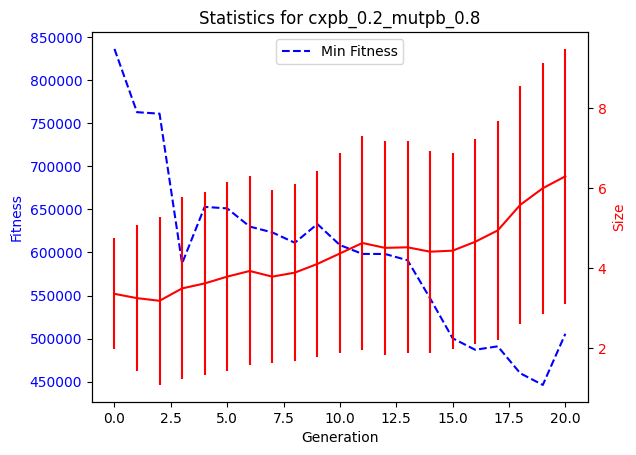

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e55aee530> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


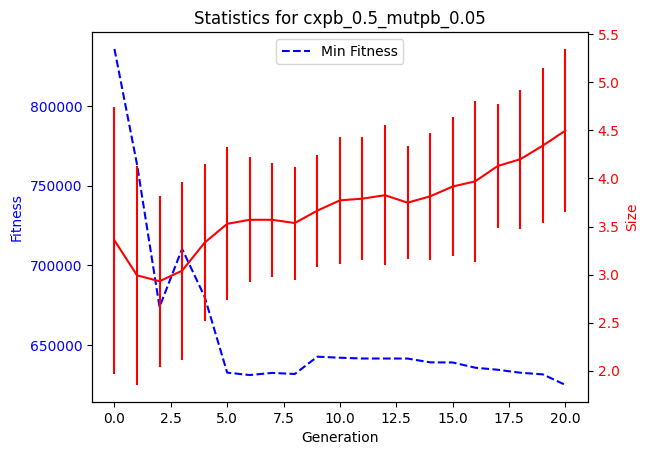

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e5558be50> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


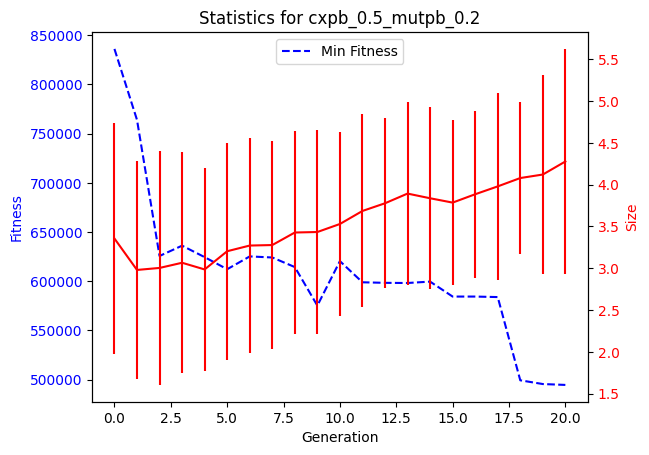

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e552c9240> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


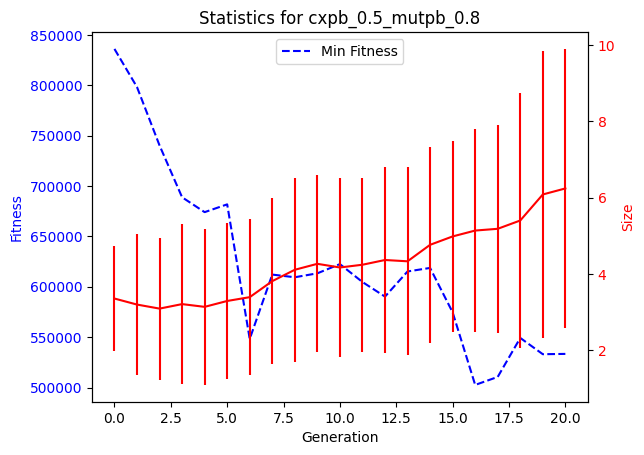

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e55356bf0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


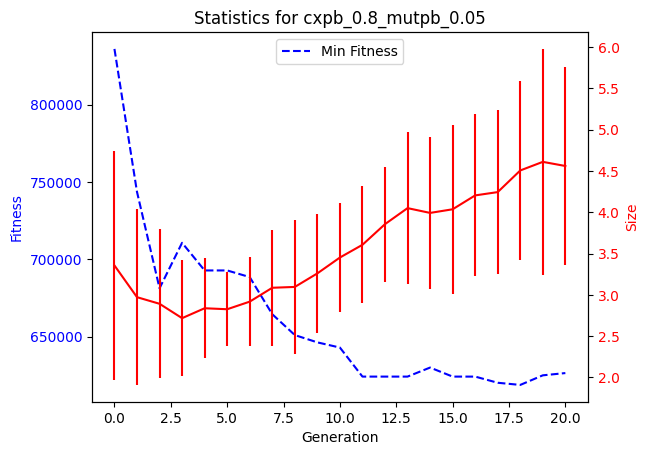

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e5518bb50> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


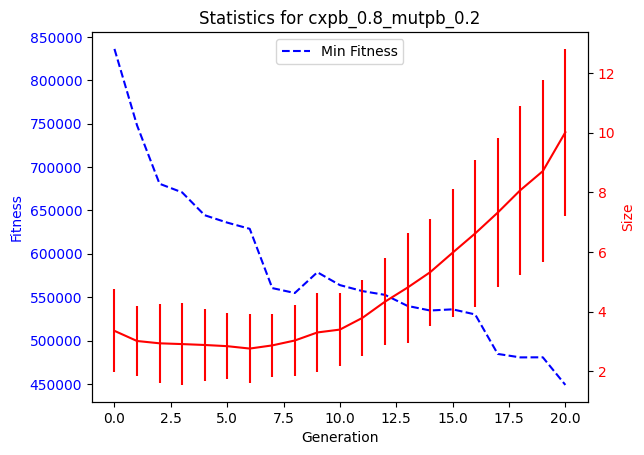

<ipython-input-22-1f67c786eef8>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7c0e550dddb0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


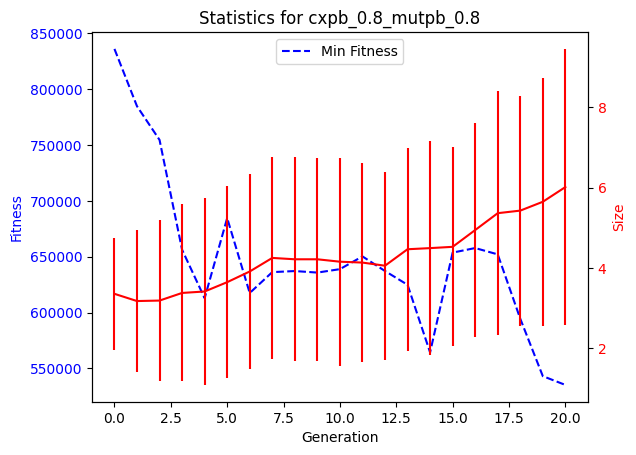

In [ ]:


import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Function to extract and average statistics from a list of logbooks
def extract_and_average_statistics(logbooks):
    n_logbooks = len(logbooks)
    generations = logbooks[0].select("gen")

    stats = {
        "gen": generations,
        "avg_fitness": np.zeros(len(generations)),
        "min_fitness": np.zeros(len(generations)),
        "max_fitness": np.zeros(len(generations)),
        "std_fitness": np.zeros(len(generations)),
        "avg_size": np.zeros(len(generations)),
        "min_size": np.zeros(len(generations)),
        "max_size": np.zeros(len(generations)),
        "std_size": np.zeros(len(generations))
    }

    for logbook in logbooks:
        stats["avg_fitness"] += np.array(logbook.chapters["fitness"].select("avg"))
        stats["min_fitness"] += np.array(logbook.chapters["fitness"].select("min"))
        stats["max_fitness"] += np.array(logbook.chapters["fitness"].select("max"))
        stats["std_fitness"] += np.array(logbook.chapters["fitness"].select("std"))
        stats["avg_size"] += np.array(logbook.chapters["size"].select("avg"))
        stats["min_size"] += np.array(logbook.chapters["size"].select("min"))
        stats["max_size"] += np.array(logbook.chapters["size"].select("max"))
        stats["std_size"] += np.array(logbook.chapters["size"].select("std"))

    for key in stats.keys():
        if key != "gen":
            stats[key] /= n_logbooks

    return stats

# Function to plot statistics
def plot_statistics(stats, title):
    fig, ax1 = plt.subplots()

    # Plot average fitness with error bars
    #ax1.errorbar(stats["gen"], stats["avg_fitness"], yerr=stats["std_fitness"], fmt='b-', label="Avg Fitness")
    ax1.plot(stats["gen"], stats["min_fitness"], "b--", label="Min Fitness")
    #ax1.plot(stats["gen"], stats["max_fitness"], "b-.", label="Max Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    # Plot average size with error bars
    ax2 = ax1.twinx()
    ax2.errorbar(stats["gen"], stats["avg_size"], yerr=stats["std_size"], fmt='r-')
    #ax2.plot(stats["gen"], stats["min_size"], "r--", label="Min Size")
    #ax2.plot(stats["gen"], stats["max_size"], "r-.", label="Max Size")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    # Combine legends
    lns = ax1.get_lines() + ax2.get_lines()
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper center")

    plt.title(title)
    plt.show()


# Function to save statistics to txt files
def save_statistics_to_txt(stats, prefix):
    np.savetxt(f"{prefix}_gen.txt", stats["gen"])
    np.savetxt(f"{prefix}_avg_fitness.txt", stats["avg_fitness"])
    np.savetxt(f"{prefix}_min_fitness.txt", stats["min_fitness"])
    np.savetxt(f"{prefix}_max_fitness.txt", stats["max_fitness"])
    np.savetxt(f"{prefix}_std_fitness.txt", stats["std_fitness"])
    np.savetxt(f"{prefix}_avg_size.txt", stats["avg_size"])
    np.savetxt(f"{prefix}_min_size.txt", stats["min_size"])
    np.savetxt(f"{prefix}_max_size.txt", stats["max_size"])
    np.savetxt(f"{prefix}_std_size.txt", stats["std_size"])


# Extract and plot statistics for each combination
for key, logbooks in grid_search_results.items():
    stats = extract_and_average_statistics(logbooks)
    plot_statistics(stats, f"Statistics for {key}")
    save_statistics_to_txt(stats, key)


# **PART 1.3/1.4: Investigation and evalution of parsimony size**

We tested the effect of 3 different parsomony sizes for double tournament within the range of 1 and 2:
* parsimony sizes = [1.0, 1.5, 1.8]

This ranges from no parsimony pressure at 1.0 - effectively acting as single tournament selection to a middle ground at 1.5 and very high pressure at 1.8. By drawing  a wide net we can get a feel for determining the right pressure sizes across these low, medium and high thresholds.

Like before we ran the same tests to see the effect of parsimony sizes on the average size and minimum fitnesses.

We ran our tests for 10 runs across random seeds to ensure reproducibility. Since this is exploratory investigation we did not choose large populations or generations due to the delay. Instead for this test the rest of the parameters were constant at:

* runs = 10, generations = 30, population size = 50, mutpb = 0.2, cxpb = 0.5

For now we chose a reasonable mutation and crossover rates at 0.2 and 0.5 so that they do not influence our results to much, drawing on the insights from the previous tests. The generations were incremented by 10 from before to observe trends for longer to ssee the continued effects of pressure.

The logbook resutls of the were stored in a dictionary for statistical analysis. The raw results of the best individual per run (since we are mainly evaluating the best solution) are tested for significance.


In [ ]:
#PARSIMONY PRESSURE TEST:
# Define your GP components (primitives, toolbox, etc.)

# Function to perform multiple runs and collect logbooks
def multiple_runs_psize(toolbox, n_runs, cxpb, mutpb, ngen, pop_size, parsimony_size):
    all_logbooks = []
    for run in range(n_runs):
        random.seed(run)  # Set the random seed for reproducibility
        np.random.seed(run)
        population = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        size_stats = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats, size=size_stats)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "nevals"] + mstats.fields

        toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=parsimony_size, fitness_first=True)

        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            ngen=ngen, stats=mstats, halloffame=hof, verbose=True
        )
        all_logbooks.append(logbook)
    return all_logbooks

# Define the parameters
n_runs = 10#10  # Reduced to 5 runs to save computation time
ngen = 30#0#20
pop_size = 50#0#50
cxpb = 0.5  # Constant value for crossover probability
mutpb = 0.2  # Constant value for mutation probability
parsimony_sizes = [1.0, 1.5, 1.8]  # Range of parsimony sizes to test

# Perform runs for different parsimony sizes
grid_search_results_psize = {}

for parsimony_size in parsimony_sizes:
    key = f"parsimony_{parsimony_size}"
    print(f"Running with parsimony size: {parsimony_size}")
    grid_search_results_psize[key] = multiple_runs_psize(toolbox, n_runs, cxpb, mutpb, ngen, pop_size, parsimony_size)


In [ ]:
# Create new dictionaries to store the statistics as lists for each combination
stats_dicts_psize = {}

for key, logbooks in grid_search_results_psize.items():
    # Initialize dictionary to hold lists for each statistic
    stats_dicts_psize[key] = {
        "avg_fitness": [],
        "min_fitness": [],
        "max_fitness": [],
        "std_fitness": [],
        "avg_size": [],
        "min_size": [],
        "max_size": [],
        "std_size": []
    }

    for logbook in logbooks:
        # Extract statistics from the last generation
        stats_dicts_psize[key]["avg_fitness"].append(logbook.chapters["fitness"].select("avg")[-1])
        stats_dicts_psize[key]["min_fitness"].append(logbook.chapters["fitness"].select("min")[-1])
        stats_dicts_psize[key]["max_fitness"].append(logbook.chapters["fitness"].select("max")[-1])
        stats_dicts_psize[key]["std_fitness"].append(logbook.chapters["fitness"].select("std")[-1])
        stats_dicts_psize[key]["avg_size"].append(logbook.chapters["size"].select("avg")[-1])
        stats_dicts_psize[key]["min_size"].append(logbook.chapters["size"].select("min")[-1])
        stats_dicts_psize[key]["max_size"].append(logbook.chapters["size"].select("max")[-1])
        stats_dicts_psize[key]["std_size"].append(logbook.chapters["size"].select("std")[-1])

# Print the number of runs for each combination and each stat for verification
for key, stats in stats_dicts_psize.items():
    print(f"{key} statistics:")
    for stat, values in stats.items():
        print(f"{stat} ({len(values)} runs): {values}")
    print("\n")
#HERE

parsimony_1.0 statistics:
avg_fitness (10 runs): [26663879.235210415, 559652.3328969893, 593298.4499207017, 53843972.72762899, 18427883.285556573, 2455473.604933288, 2234874.6087660845, 44582477.3514876, 4937531991.503766, 2860650409.3311787]
min_fitness (10 runs): [309489.5042124001, 479164.7050428796, 482408.87731449597, 345472.6071910409, 260948.80690197312, 235639.71372274324, 432115.7807124001, 265214.8760705479, 266747.4072086832, 398117.578355508]
max_fitness (10 runs): [1208739878.3922746, 1172429.5486586757, 3178566.543850911, 1204404929.5197816, 699329711.1683158, 91798558.28573556, 20132530.57234589, 1763186576.6908984, 246657625718.03033, 142636498545.16812]
std_fitness (10 runs): [169464605.2740898, 173288.31750358903, 438800.2434905173, 197370443.53879625, 100584121.0191002, 12836499.527904106, 4682555.139568739, 253233396.8191517, 34531448180.05732, 19968000050.725975]
avg_size (10 runs): [9.18, 2.98, 28.8, 5.14, 14.48, 9.82, 5.76, 12.84, 7.54, 9.06]
min_size (10 runs): 

We ran the same statistical tests as well as plotting te box plots and fitness-size-generation trend plots like our prior investigation. This time our statistical tests were significant as shown below afte rthe code block.

In [ ]:
# Import necessary libraries for statistical tests
from scipy.stats import kruskal
import scikit_posthocs as sp


# Extract min_fitness values for all combinations
min_fitness_values_psize = []
labels_psize = []
for key, stats in stats_dicts_psize.items():
    min_fitness_values_psize.append(stats["min_fitness"])
    labels_psize.extend([key] * len(stats["min_fitness"]))

# Perform Kruskal-Wallis test on min_fitness values
kruskal_result_psize = kruskal(*min_fitness_values_psize)
print(f"Kruskal-Wallis H-statistic: {kruskal_result_psize.statistic}, p-value: {kruskal_result_psize.pvalue}")

# Interpret the Kruskal-Wallis test result
if kruskal_result_psize.pvalue < 0.05:
    print("There are statistically significant differences between the groups.")
else:
    print("There are no statistically significant differences between the groups.")

# Prepare data for Dunn's test
data_psize = pd.DataFrame({
    'min_fitness': [item for sublist in min_fitness_values_psize for item in sublist],
    'group': labels_psize
})

# Perform Dunn's test for post hoc analysis
dunn_results_psize = sp.posthoc_dunn(data_psize, val_col='min_fitness', group_col='group', p_adjust='bonferroni')
print(dunn_results_psize)


Kruskal-Wallis H-statistic: 17.26382835317906, p-value: 0.00017832297659526735
There are statistically significant differences between the groups.
               parsimony_1.0  parsimony_1.5  parsimony_1.8
parsimony_1.0       1.000000       0.067025       0.000101
parsimony_1.5       0.067025       1.000000       0.187242
parsimony_1.8       0.000101       0.187242       1.000000




---
The above results are the K.Wallis scores for the minimum fitnesses for the 10 runs across the 3 parsimony sizes:

The p-value from the K.Wallis test is very significant at 0.00018. Looking at the Dunns test results we can see the following significances:
* Pvalue: parsimony 1.0 and parsimony 1.5 = 0.067 -> This shows some level of significance that is almost statistically significant.

* Pvalue: parsimony 1.5 and parsimony 1.8 = 0.18 ->The same applies for parsimony 1.5 and 1.8 as p value is 0.18 although it is much less statistically significant in their differnces.

* Pvalue: parsimony 1.0 and parsimony 1.8 = 0.0001 -> they have the strongest statistically significant difference in minimum fitnesses with a p-value of 0.0001.

 Clearly, varying the parsimony pressure / size has significant effect on our fitnesses despite an indirect relationship with the tree size, but why? We again look at the fitness plots to observe why parsimony pressure and size have an effect on fitness.

<ipython-input-28-18e8cb66980e>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x78934be07ca0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


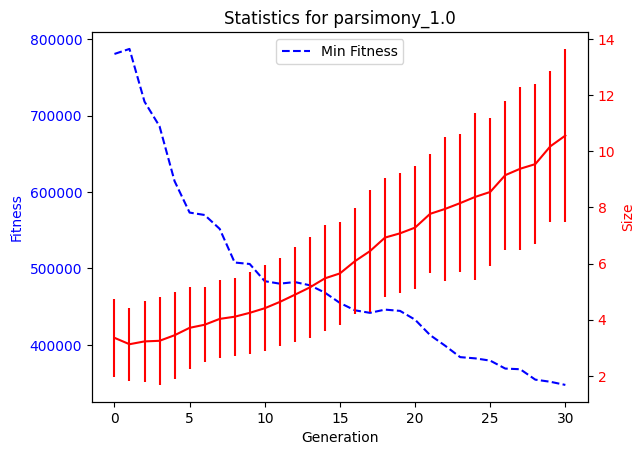

<ipython-input-28-18e8cb66980e>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x78934bd04d90> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


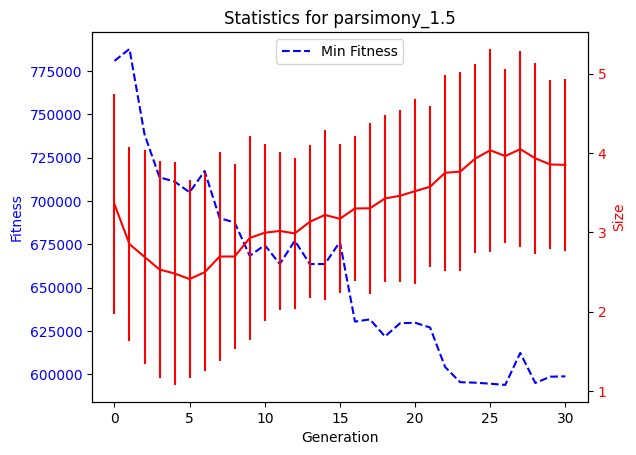

<ipython-input-28-18e8cb66980e>:70: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x78934bdd4f40> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


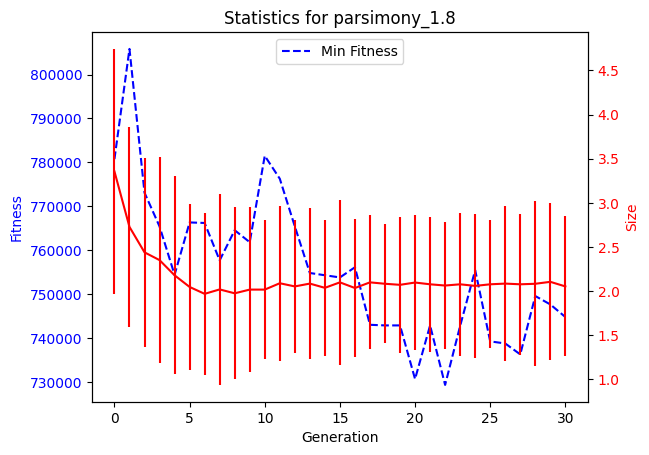

In [ ]:

import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Function to extract and average statistics from a list of logbooks
def extract_and_average_statistics(logbooks):
    n_logbooks = len(logbooks)
    generations = logbooks[0].select("gen")

    stats = {
        "gen": generations,
        "avg_fitness": np.zeros(len(generations)),
        "min_fitness": np.zeros(len(generations)),
        "max_fitness": np.zeros(len(generations)),
        "std_fitness": np.zeros(len(generations)),
        "avg_size": np.zeros(len(generations)),
        "min_size": np.zeros(len(generations)),
        "max_size": np.zeros(len(generations)),
        "std_size": np.zeros(len(generations))
    }

    for logbook in logbooks:
        stats["avg_fitness"] += np.array(logbook.chapters["fitness"].select("avg"))
        stats["min_fitness"] += np.array(logbook.chapters["fitness"].select("min"))
        stats["max_fitness"] += np.array(logbook.chapters["fitness"].select("max"))
        stats["std_fitness"] += np.array(logbook.chapters["fitness"].select("std"))
        stats["avg_size"] += np.array(logbook.chapters["size"].select("avg"))
        stats["min_size"] += np.array(logbook.chapters["size"].select("min"))
        stats["max_size"] += np.array(logbook.chapters["size"].select("max"))
        stats["std_size"] += np.array(logbook.chapters["size"].select("std"))

    for key in stats.keys():
        if key != "gen":
            stats[key] /= n_logbooks

    return stats

# Function to plot statistics
def plot_statistics(stats, title):
    fig, ax1 = plt.subplots()

    # Plot average fitness with error bars
    #ax1.errorbar(stats["gen"], stats["avg_fitness"], yerr=stats["std_fitness"], fmt='b-', label="Avg Fitness")
    ax1.plot(stats["gen"], stats["min_fitness"], "b--", label="Min Fitness")
    #ax1.plot(stats["gen"], stats["max_fitness"], "b-.", label="Max Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    # Plot average size with error bars
    ax2 = ax1.twinx()
    ax2.errorbar(stats["gen"], stats["avg_size"], yerr=stats["std_size"], fmt='r-', label="Avg Size")
    #ax2.plot(stats["gen"], stats["min_size"], "r--", label="Min Size")
    #ax2.plot(stats["gen"], stats["max_size"], "r-.", label="Max Size")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    # Combine legends
    lns = ax1.get_lines() + ax2.get_lines()
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper center")

    plt.title(title)
    plt.show()


# Function to save statistics to txt files
def save_statistics_to_txt(stats, prefix):
    np.savetxt(f"{prefix}_gen.txt", stats["gen"])
    np.savetxt(f"{prefix}_avg_fitness.txt", stats["avg_fitness"])
    np.savetxt(f"{prefix}_min_fitness.txt", stats["min_fitness"])
    np.savetxt(f"{prefix}_max_fitness.txt", stats["max_fitness"])
    np.savetxt(f"{prefix}_std_fitness.txt", stats["std_fitness"])
    np.savetxt(f"{prefix}_avg_size.txt", stats["avg_size"])
    np.savetxt(f"{prefix}_min_size.txt", stats["min_size"])
    np.savetxt(f"{prefix}_max_size.txt", stats["max_size"])
    np.savetxt(f"{prefix}_std_size.txt", stats["std_size"])


# Extract and plot statistics for each combination
for key, logbooks in grid_search_results_psize.items():
    stats = extract_and_average_statistics(logbooks)
    plot_statistics(stats, f"Statistics for {key}")
    save_statistics_to_txt(stats, key)




---
As per the plots for average Statistics for parsimony_1.0, parsimony_1.5 and parsimony_1.8 across 10 runs above we have make the following observations. At a quick glance, we see these final mean best fitness (MBF) values for the pressures:
* Parsimony Size 1.0: 300,000 approx.
* Parsimony Size 1.5: 600,000 approx.
* Parsimony Size 1.8: 740,000 approx.

With reference to our p-values from before which suggests that the differnce in our mean best (minimum) fitnesses are statistically significant the larger the pvalue, we can deduce that as the pressure increases the mean best fitness decreases. More precisely, it causes the size of our solutions to increase more leading to fitter solutions.

However, this comes at the cost of increasing bloat as seen in the plots above:
* Parsimony size 1.0: Essentially acting as tournament selection with no pressure, we obtain a very smooth convergence of our fitness towards a very low minimum fitness nearing 300,000 on average but the average size increases almost inversely with increasing standard deviation. This suggest we potentially end up with a very bloated solution near the end which is undesirable although convergence is easy.
* Parsimony size 1.5: With a more balanced approach the plot shows that our mean best fitness line struggles a bit more to traverse the fitness landscape due to the size constrainsts with more random fluctuations in the fitness line. It also converges to a worse fitness than without any pressure. But the average size shows signs of adaptation - initially decreasing then increasing and decreasing again. At the very least the size increase is less steep and more balanced. Although this makes it harder to traverse the fitness landscape it helps reduce bloat.
* Parsimony size 1.8: With a higher pressure size we now have even more fluctuations in the fintess landscape and even show signs of being stuck at a local minima around 740,000 mse. Ths can be attributed to the pressure pushing down the diversity of the size of pour individuals down to an average of 2. This suggests that at that size we might not find an efficient solutions quickly enough.

Hence, a balancced pressure size between 1.2 and 1.5 is preferable to evolve good solutions with reasonable convergece of fitness.




---


# **PART 1.3/1.4: Investigation and evalution of population size**

We tested the effect of 3 different population sizes for our GP. Normally the usage of very large populations are common for GP algorithm. However due to the time and resouce constraints we limited ourselves to a more reasonable range for running multiple times:

* population sizes = [30,100,300]

This range allows us to see if maybe we might have a regression problem that is not too complex and could maybe be solved with a smaller population first before moving to larger sizes as larger populations do come with higher computational costs. We would like to minimise that as much as possible while reaching to a good MSE value at a reasonable generation.

Like before we ran the same tests to see the effect of parsimony sizes on the average size and minimum fitnesses.

We ran our tests for 10 runs across random seeds to ensure reproducibility. Since this is exploratory investigation we did not choose large populations or generations due to the delay. Instead for this test the rest of the parameters were constant at:

* runs = 5, generations = 10,  mutpb = 0.2, cxpb = 0.5

For now we chose a reasonable mutation and crossover rates at 0.2 and 0.5 so that they do not influence our results to much, drawing on the insights from the previous tests. The generations and number of runs were reduced due to the time constraints of large populations being evolved. The parsimony pressure was also reduced to 1.25 to allow for a less constrained analyisis of populations effect on size.

The logbook resutls of the were stored in a dictionary for statistical analysis. The raw results of the best individual per run (since we are mainly evaluating the best solution) are tested for significance.


In [ ]:
#POP SIZE TEST:
# Define your GP components (primitives, toolbox, etc.)

# Function to perform multiple runs and collect logbooks
def multiple_runs_popsize(toolbox, n_runs, cxpb, mutpb, ngen, pop_size, parsimony_size):
    all_logbooks = []
    for run in range(n_runs):
        random.seed(run)  # Set the random seed for reproducibility
        np.random.seed(run)
        population = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        size_stats = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats, size=size_stats)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "nevals"] + mstats.fields

        toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=parsimony_size, fitness_first=True)

        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            ngen=ngen, stats=mstats, halloffame=hof, verbose=True
        )
        all_logbooks.append(logbook)
    return all_logbooks

# Define the parameters
n_runs = 5#10  # Reduced to 5 runs to save computation time
ngen = 10#0#20
pop_sizes = [30, 100, 300]#0#50
cxpb = 0.5  # Constant value for crossover probability
mutpb = 0.2  # Constant value for mutation probability
parsimony_size = 1.25  # Range of parsimony sizes to test

# Perform runs for different parsimony sizes
grid_search_results_popsize = {}

for pop in pop_sizes:
    key = f"pop_{pop}"
    print(f"Running with pop size: {pop}")
    grid_search_results_popsize[key] = multiple_runs_popsize(toolbox, n_runs, cxpb, mutpb, ngen, pop, parsimony_size)


In [ ]:
# Create new dictionaries to store the statistics as lists for each combination
stats_dicts_popsize = {}

for key, logbooks in grid_search_results_popsize.items():
    # Initialize dictionary to hold lists for each statistic
    stats_dicts_popsize[key] = {
        "avg_fitness": [],
        "min_fitness": [],
        "max_fitness": [],
        "std_fitness": [],
        "avg_size": [],
        "min_size": [],
        "max_size": [],
        "std_size": []
    }

    for logbook in logbooks:
        # Extract statistics from the last generation
        stats_dicts_popsize[key]["avg_fitness"].append(logbook.chapters["fitness"].select("avg")[-1])
        stats_dicts_popsize[key]["min_fitness"].append(logbook.chapters["fitness"].select("min")[-1])
        stats_dicts_popsize[key]["max_fitness"].append(logbook.chapters["fitness"].select("max")[-1])
        stats_dicts_popsize[key]["std_fitness"].append(logbook.chapters["fitness"].select("std")[-1])
        stats_dicts_popsize[key]["avg_size"].append(logbook.chapters["size"].select("avg")[-1])
        stats_dicts_popsize[key]["min_size"].append(logbook.chapters["size"].select("min")[-1])
        stats_dicts_popsize[key]["max_size"].append(logbook.chapters["size"].select("max")[-1])
        stats_dicts_popsize[key]["std_size"].append(logbook.chapters["size"].select("std")[-1])

# Print the number of runs for each combination and each stat for verification
for key, stats in stats_dicts_popsize.items():
    print(f"{key} statistics:")
    for stat, values in stats.items():
        print(f"{stat} ({len(values)} runs): {values}")
    print("\n")
#HERE

pop_30 statistics:
avg_fitness (5 runs): [645854.5012667892, 835480.6677328412, 857268.1470280052, 888424.1850281052, 5113461189.376392]
min_fitness (5 runs): [346427.809905444, 774307.2036244292, 826974.414577863, 583325.3202811072, 645914.3737591677]
max_fitness (5 runs): [1163142.198487443, 2140088.7248858446, 911866.5988921351, 1571650.8964349946, 153379126167.40668]
std_fitness (5 runs): [198214.0614206938, 245185.43008243435, 28373.492175615494, 149422.4399427624, 27532242798.24057]
avg_size (5 runs): [3.3666666666666667, 2.9, 4.2, 3.1333333333333333, 3.3]
min_size (5 runs): [1, 1, 2, 1, 1]
max_size (5 runs): [8, 4, 7, 10, 8]
std_size (5 runs): [1.4255603186895398, 0.5972157622389639, 1.0456258094238748, 2.0450482200237294, 2.4378952670968728]


pop_100 statistics:
avg_fitness (5 runs): [286679903.7545921, 10593884479.841711, 2766054.4849125384, 321280598.88419974, 50050737112.818665]
min_fitness (5 runs): [346427.809905444, 464647.3126901858, 472918.2124714612, 472918.2124714612



---


Running our kruswal wallis tests like before, we resulted in statistically significant differences in our minimum fitnesses across the 3 pop sizes as shown after the code block.

In [ ]:
#MINIMUM FITNESS
kruskal_result_avg_size, dunn_results_avg_size = perform_statistical_tests(stats_dicts_popsize, stat_type='min_fitness')

print(kruskal_result_avg_size)
print(dunn_results_avg_size)

Kruskal-Wallis H-statistic: 6.228985507246377, p-value: 0.044401023694683225
There are statistically significant differences between the groups.
          pop_100    pop_30   pop_300
pop_100  1.000000  0.763434  0.527972
pop_30   0.763434  1.000000  0.038028
pop_300  0.527972  0.038028  1.000000
KruskalResult(statistic=6.228985507246377, pvalue=0.044401023694683225)
          pop_100    pop_30   pop_300
pop_100  1.000000  0.763434  0.527972
pop_30   0.763434  1.000000  0.038028
pop_300  0.527972  0.038028  1.000000




---

The above results are the K.Wallis scores for the minimum fitnesses for the 5 runs across the 3 population sizes:

The p-value from the K.Wallis test is significant at 0.044. Looking at the Dunns test results we can see the following significances:
* Pvalue: population 30 and parsimony 100 = 0.76 -> This shows some level of significance but it is not statistically significant.

* Pvalue: population 100 and population 300 = 0.52 -> The same applies for this pair although it is much more significant in their differnces with a lower p value since the population sizes are further from each other.

* Pvalue: population 30 and population 300 = 0.038 -> they have the strongest statistically significant difference in minimum fitnesses with a p-value of 0.0001.

 Clearly, varying the population size has significant effect on our fitnesses  and as the size increases so does the statistical difference in the minimum fitnesses. We want to further evaluate this with box plots and fitness plots below.



---

Most of our statistics are not rasonably affected by the population size. THe key things to note are:
* As per box plot for min_fitness, we can clearly see the mean fitness decrease significantly with an increase in population as suggested by the statistical tests above with population 300 having the best minimum fitness.
* As per box plot for avg_size, we also have some indication that the average size is generally lower at smaller populations further fortifying the inverse relationship between size and fitness.

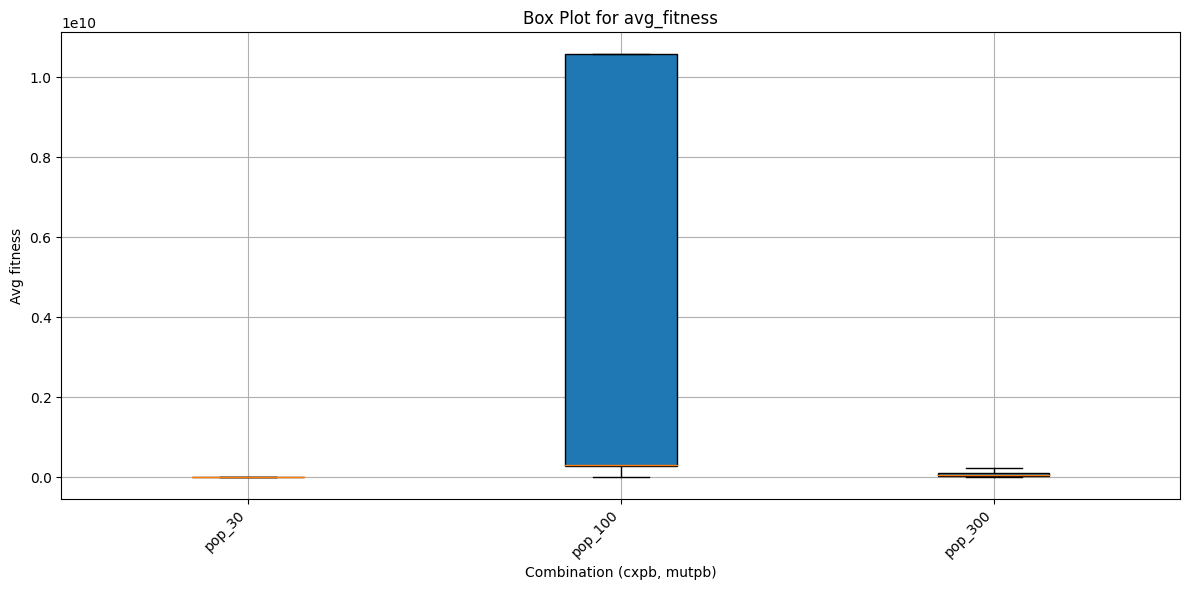

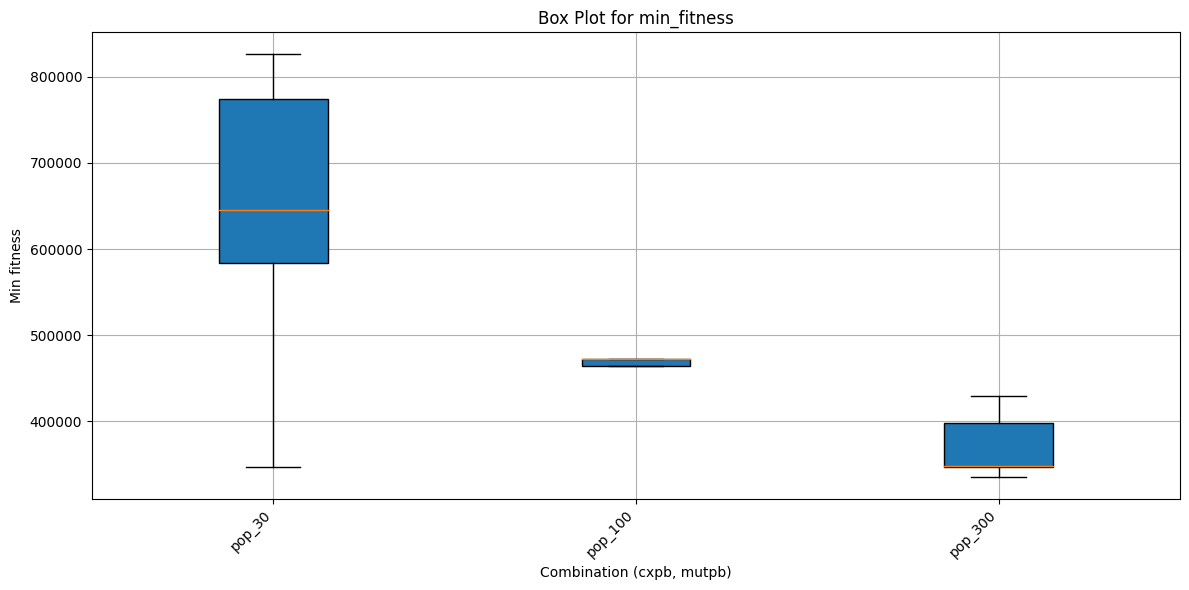

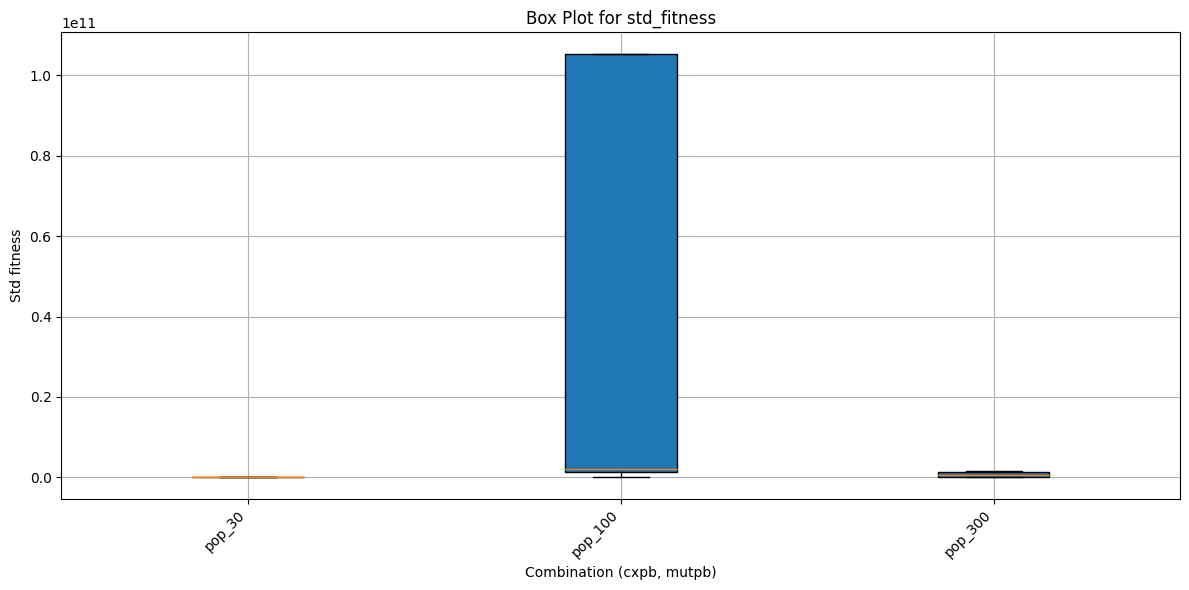

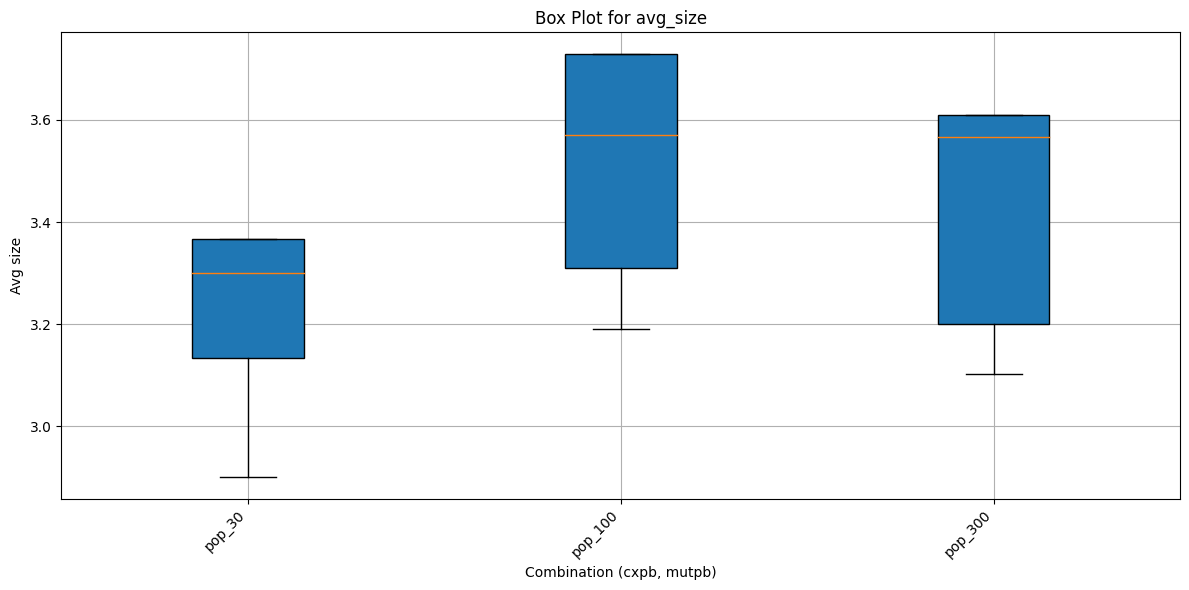

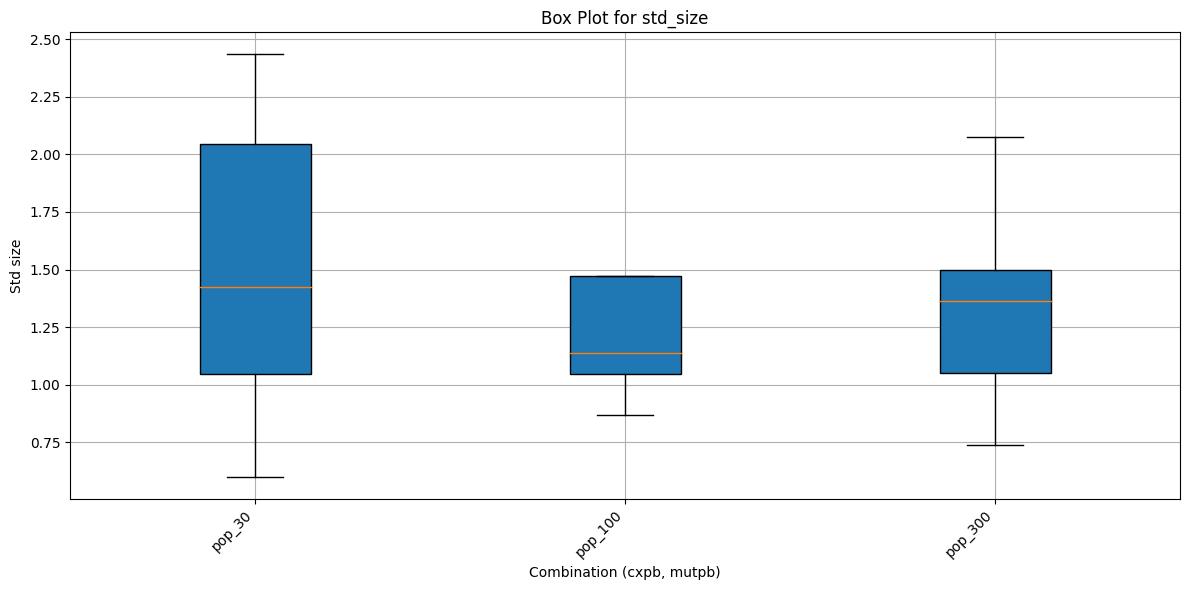

In [ ]:
# Example usage
plot_boxplot_for_stat(stats_dicts_popsize, stat_type='avg_fitness')
plot_boxplot_for_stat(stats_dicts_popsize, stat_type='min_fitness')
plot_boxplot_for_stat(stats_dicts_popsize, stat_type='std_fitness')

plot_boxplot_for_stat(stats_dicts_popsize, stat_type='avg_size')
plot_boxplot_for_stat(stats_dicts_popsize, stat_type='std_size')

<ipython-input-39-64e2885fd0c2>:71: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7df26c763850> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


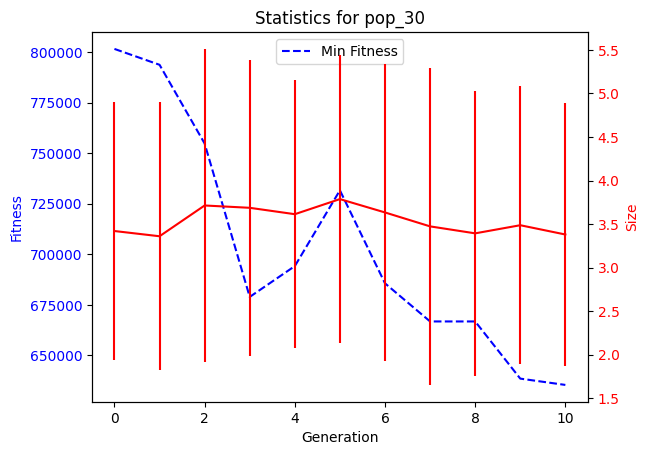

<ipython-input-39-64e2885fd0c2>:71: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7df26c955a80> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


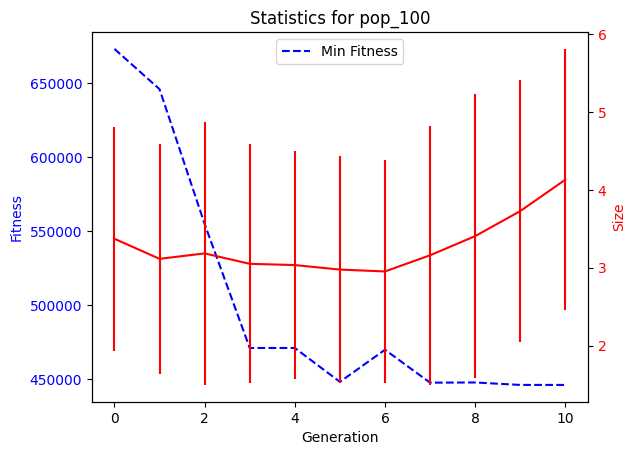

<ipython-input-39-64e2885fd0c2>:71: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x7df26cb921a0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns, labs, loc="upper center")


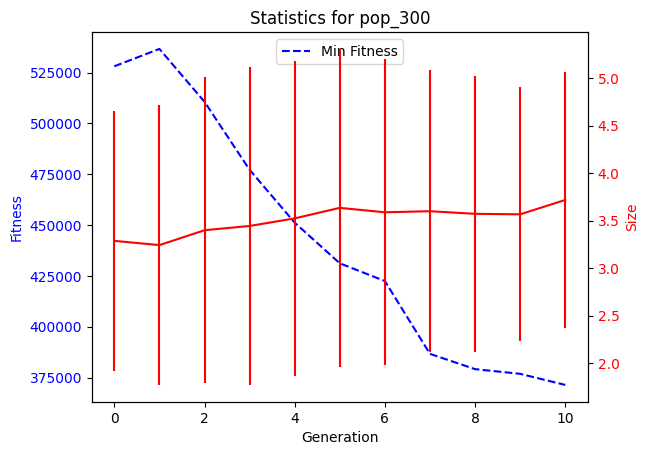

In [ ]:

import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Function to extract and average statistics from a list of logbooks
def extract_and_average_statistics(logbooks):
    n_logbooks = len(logbooks)
    generations = logbooks[0].select("gen")

    stats = {
        "gen": generations,
        "avg_fitness": np.zeros(len(generations)),
        "min_fitness": np.zeros(len(generations)),
        "max_fitness": np.zeros(len(generations)),
        "std_fitness": np.zeros(len(generations)),
        "avg_size": np.zeros(len(generations)),
        "min_size": np.zeros(len(generations)),
        "max_size": np.zeros(len(generations)),
        "std_size": np.zeros(len(generations))
    }

    for logbook in logbooks:
        stats["avg_fitness"] += np.array(logbook.chapters["fitness"].select("avg"))
        stats["min_fitness"] += np.array(logbook.chapters["fitness"].select("min"))
        stats["max_fitness"] += np.array(logbook.chapters["fitness"].select("max"))
        stats["std_fitness"] += np.array(logbook.chapters["fitness"].select("std"))
        stats["avg_size"] += np.array(logbook.chapters["size"].select("avg"))
        stats["min_size"] += np.array(logbook.chapters["size"].select("min"))
        stats["max_size"] += np.array(logbook.chapters["size"].select("max"))
        stats["std_size"] += np.array(logbook.chapters["size"].select("std"))

    for key in stats.keys():
        if key != "gen":
            stats[key] /= n_logbooks

    return stats

# Function to plot statistics
def plot_statistics(stats, title):
    fig, ax1 = plt.subplots()

    # Plot average fitness with error bars
    #ax1.errorbar(stats["gen"], stats["avg_fitness"], yerr=stats["std_fitness"], fmt='b-', label="Avg Fitness")
    ax1.plot(stats["gen"], stats["min_fitness"], "b--", label="Min Fitness")
    #ax1.plot(stats["gen"], stats["max_fitness"], "b-.", label="Max Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    # Plot average size with error bars
    ax2 = ax1.twinx()
    ax2.errorbar(stats["gen"], stats["avg_size"], yerr=stats["std_size"], fmt='r-', label="Avg Size")
    #ax2.plot(stats["gen"], stats["avg_size"], "r-.", label="avg Size")
    #ax2.plot(stats["gen"], stats["min_size"], "r--", label="Min Size")
    #ax2.plot(stats["gen"], stats["max_size"], "r-.", label="Max Size")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    # Combine legends
    lns = ax1.get_lines() + ax2.get_lines()
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper center")

    plt.title(title)
    plt.show()


# Function to save statistics to txt files
def save_statistics_to_txt(stats, prefix):
    np.savetxt(f"{prefix}_gen.txt", stats["gen"])
    np.savetxt(f"{prefix}_avg_fitness.txt", stats["avg_fitness"])
    np.savetxt(f"{prefix}_min_fitness.txt", stats["min_fitness"])
    np.savetxt(f"{prefix}_max_fitness.txt", stats["max_fitness"])
    np.savetxt(f"{prefix}_std_fitness.txt", stats["std_fitness"])
    np.savetxt(f"{prefix}_avg_size.txt", stats["avg_size"])
    np.savetxt(f"{prefix}_min_size.txt", stats["min_size"])
    np.savetxt(f"{prefix}_max_size.txt", stats["max_size"])
    np.savetxt(f"{prefix}_std_size.txt", stats["std_size"])


# Extract and plot statistics for each combination
for key, logbooks in grid_search_results_popsize.items():
    stats = extract_and_average_statistics(logbooks)
    plot_statistics(stats, f"Statistics for {key}")
    #save_statistics_to_txt(stats, key)




---
As per the plots for average Statistics for pop_30, pop_100 and pop_300 across 5 runs above we have make the following observations. At a quick glance, we see these final mean best fitness (MBF) values decreasing with population:
* Pop size 30: 600,000 approx.
* Pop Pop 100: 450,000 approx.
* Parsimony Size 300:375,000 approx.

With reference to our p-values from before which suggests that the differnce in our mean best (minimum) fitnesses are statistically significant the larger the populatio size. What's also interesting is that according to our plots we also  obtain lower initial mean best fitness values as population increases.
* Pop size 30: 800,000 approx. initially
* Pop Pop 100: 670,000 approx. initially
* Pop Size 300: 525,000 approx. initially

This makes sense due to the initial population having more diversity of individuals as the size of the population increases.


---


# **PART 1.4: EVALUATION OF SOLUTION**

With a better understanding of the choice of parameters and representation and its effect on our algorithm we then incrementally develop and evaluate our algorithms. Our goal would be to develop a GP algorithm that reliably evolves solutions with low MSE fitness, low tree size and has a good r2 score on our test data. Ideally it would achieve this at a reasonably low population size and number of generations.


---
Based on our investigations and evaluations above we have 2 combinations of crossover and mutation rates to choose from: (0.5 cxpb and 0.2 mutpb) or (0.8 cxpb and 0.2 mutpb).

We want to avoid the destructive effects of high crossover rates on GP tree representations. This happens as the GP progresses evolution in evolving and assembling small trees into larger and larger trees, the whole structure becomes more and more fragile - more prone to be broken up by subsequent crossovers. Or good sub trees might be crossed over with a worse tree section and we end up losing the good solution.

While our tests did not necessarily showcase this, high crossover also makes evolution more computationally expensive as we have to crossover more and more evolving individuals. This was apparent from running our tests as 0.8 crossovers took significantly longer to run.

Hence (0.5 cxpb and 0.2 mutpb) was chosen for our solution.


---

A balanced parsimony size of 1.5 was chosen to ensure we obtain reasonably sized trees. This could be reduced if needed. We chose a population size of 100 which is reasonably small for GP regression. This felt like a good middle groudn between obtaining good solutions and computational efficiency. We chose 100 generations to train initially. To avoid timeouts on collab the number of runs were reduced to 3 runs which does effect our reproducability but we had to make a compromise to evolve our GP solution fully.


---




In [ ]:
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms

# Function to perform multiple runs and collect logbooks and final populations
def multiple_runs_test1(toolbox, n_runs, cxpb, mutpb, ngen, pop_size, parsimony_size):
    all_logbooks = []
    final_populations = []
    best_individuals = []

    for run in range(n_runs):
        random.seed(run)  # Set the random seed for reproducibility
        np.random.seed(run)
        population = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        size_stats = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats, size=size_stats)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "nevals"] + mstats.fields

        toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=parsimony_size, fitness_first=True)

        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            ngen=ngen, stats=mstats, halloffame=hof, verbose=True
        )

        all_logbooks.append(logbook)
        final_populations.append(population)
        best_individuals.append(hof[0])

    return all_logbooks, final_populations, best_individuals

# Define the parameters
n_runs = 3  # Reduced to 3 runs to save computation time
ngen = 100
pop_sizes = [300]
cxpb = 0.5  # Constant value for crossover probability
mutpb = 0.2  # Constant value for mutation probability
parsimony_size = 1.5  # Range of parsimony sizes to test

# Perform runs for different population sizes
grid_search_results_test1 = {}
final_populations_results_test1 = {}
best_individuals_results_test1 = {}

for pop in pop_sizes:
    key = f"pop_{pop}"
    print(f"Running with pop size: {pop}")
    logbooks, final_populations, best_individuals = multiple_runs_test1(toolbox, n_runs, cxpb, mutpb, ngen, pop, parsimony_size)
    grid_search_results_test1[key] = logbooks
    final_populations_results_test1[key] = final_populations
    best_individuals_results_test1[key] = best_individuals




In [ ]:
#Accessing logbooks and final populations
for key, logbooks in grid_search_results_test1.items():
    final_pops = final_populations_results_test1[key]
    best_inds = best_individuals_results_test1[key]
    print(f"\nResults for {key}:")
    for i, (logbook, final_pop, best_ind) in enumerate(zip(logbooks, final_pops, best_inds)):
        print(f"Run {i + 1} - Final Population Size: {len(final_pop)}")
        print(f"Best Individual Fitness: {best_ind.fitness.values[0]}")
        print(f"Best Individual: {best_ind}")



Results for pop_300:
Run 1 - Final Population Size: 300
Best Individual Fitness: 246853.15685669793
Best Individual: mul(x11, sin(x16))
Run 2 - Final Population Size: 300
Best Individual Fitness: 246853.15685669793
Best Individual: mul(x11, sin(x16))
Run 3 - Final Population Size: 300
Best Individual Fitness: 246853.15685669793
Best Individual: mul(x11, mul(sin(x16), mul(x10, x10)))




---
According to the resutls above: From our 3 runs we returned the 3 best solutions obtained along with their minimum fitness and tree representation. We managed to obtain a mean best fitness of 246,853 MSE from the 3 runs. However, all 3 runs produced the same minimum fitness which suggests they might be stuck at a local minima.

The results above show that we have obtained 2 different individuals across the 3 runs:
* The first 2 runs found the inidividual: mul(x11, sin(x16))
* THe third run found a slightly bloated version of the same individual: mul(x11, mul(sin(x16), mul(x10, x10)))

THe common subtree that is helping to produce the good solution is the small tree: mul(x11, sin(x16))


In [ ]:
# Retrieve the best individual from the final population
best_individual = final_populations_results_test1["pop_300"][0][-1]  # Adjust the keys as necessary
print(best_individual) # mul(x16, x11)

mul(x16, x11)


NameError: name 'hof' is not defined



---

We decided to evaluate the individual: mul(x11, sin(x16)) on the test set to see how the MSE would vary and how well it would model against the test set by also evalauting the models R2 score. This is a value between 0 and 1 and the higher the value the better the fit. We plotted a scatter plot of our predictions by the individual against the actual outputs of the test set.

Test MSE: 273441.1598173516
Test R² Score: 0.36629068631985673


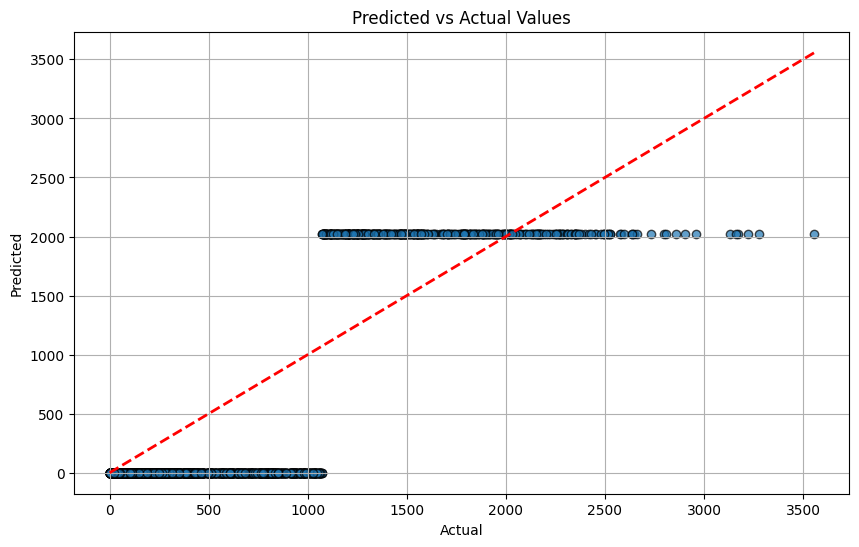

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Define a function to evaluate the best individual
def evaluate_best_individual(best_individual, X_test, y_test):
    # Compile the individual to a callable function
    func = toolbox.compile(expr=best_individual)

    # Apply the function to the test data
    predictions = np.array([func(*row) for row in X_test])

    # Calculate the fitness (MSE) on the test set
    mse = mean_squared_error(y_test, predictions)

    # Calculate the R² score on the test set
    r2 = r2_score(y_test, predictions)

    # Print the results
    print(f"Test MSE: {mse}")
    print(f"Test R² Score: {r2}")

    # Plot the predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, edgecolor='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual Values')
    plt.grid(True)
    plt.show()

    return mse, r2

# Ensure X_test and y_test are numpy arrays for compatibility
X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluate the best individual on the test set
mse, r2 = evaluate_best_individual(best_individual, X_test, y_test)


Our evolved individual achieved a TEST MSE of 273,441 which is slightly higher comapred to our TRAIN MSE of 246,853. This results in a generalization gap of 26,588. While our model has evolve a better solution than in our investivation stage the plot and R2 score show us that the model is quite limiting.

Most of the output predictions are concentrated along 2 points in the Y axis with incredibly high variance in the X axis. As inferrable from the size of our model it is too simple to represent the actual model which is more complex. In conclusion it does not generate a good enough regression model. THe R2 score fortifies this with a low score of just 0.366 indicating low correlation. We ideally want some sort of prediction that matches the red guideline for the perfect solution.


---

We plot our tree after the code below. It is incredibly simple and contains just one multiplication function between feature 16 and 11. Given its size that seems like a decent start though.

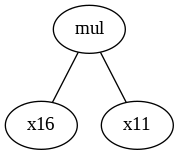

In [ ]:

nodes, edges, labels = gp.graph(best_individual)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]
treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

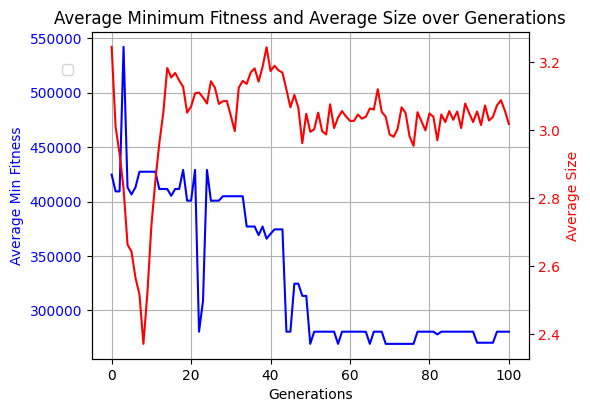

In [ ]:
# DATA WAS LOST SO HAD TO MANUALLY ENTER DATA INTO LISTS: not enough time to rerun tests
import matplotlib.pyplot as plt
import numpy as np
# Data for Run 1
run1_min_fitness = [
    280018, 280018, 280018, 678294, 678294, 658554, 678294, 636590, 636590, 636590,
    636590, 636590, 588957, 588957, 588957, 570217, 588957, 588957, 641510, 641510,
    641510, 641510, 280422, 280422, 641510, 641510, 641510, 641510, 653670, 653670,
    653670, 653670, 653670, 653670, 570217, 570217, 570217, 570217, 570217, 570217,
    550076, 562408, 562408, 562408, 280422, 280422, 412690, 412690, 412690, 412690,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422
]
run1_avg_size = [
    3.23, 2.94, 2.83333, 2.80667, 2.64333, 2.50667, 2.3, 2.21, 1.94, 2.04333,
    2.22, 2.54667, 2.77667, 3.03333, 3.29333, 3.21333, 3.26, 3.28, 3.23, 3.17333,
    3.21, 3.23333, 3.22333, 3.25, 3.24333, 3.32333, 3.27, 3.21667, 3.19667, 3.21,
    3.15333, 3.18, 3.25667, 3.23667, 3.2, 3.36, 3.35333, 3.39, 3.46, 3.53333,
    3.48333,3.39333, 3.35, 3.32, 3.35, 3.30667, 3.27333, 3.15, 2.98333, 3.05667, 3.04333,
    2.94667, 2.99333, 3.06, 3.05667, 3.05, 3.05, 3.07, 3.12333, 2.98667,
    2.96667, 2.96, 3.08667, 3.10333, 3.10667, 3.07333, 3.10667, 3.17, 3.06667, 3.02667,
    2.97333, 3.03, 3.03333, 3.08667, 3.08333, 2.92333, 2.9, 3.09, 2.98, 2.97333,
    2.98333, 3.11333, 2.94667, 2.99333, 3.06, 3.05667, 3.05, 3.05, 3.07, 3.12333,
    2.98667, 2.96667, 2.96, 3.08667, 3.10333, 3.10667, 3.07333, 3.10667, 3.17, 3.06667, 3.02
]

# List of fitness minimum numbers
run2_min_fitness = [
    713760, 667484, 667484, 667484, 280422, 280422, 280422, 365077, 365077, 365077,
    365077, 365077, 365077, 365077, 365077, 365077, 365077, 365077, 365077, 280422,
    280422, 365077, 280422, 365077, 365077, 280035, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 256681, 280422, 246853,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 246853, 246853,
    246853, 246853, 246853, 246853, 246853, 246853, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422
]

# List of average size numbers
run2_avg_size = [
    3.22, 3.02667, 2.87, 2.63333, 2.39667, 2.27333, 2.19333, 2.10667, 2.07667, 2.45333,
    2.78333, 2.97, 2.98, 3.07, 3.12333, 3.12, 3.09, 3.13667, 3.14333, 3.05333, 3.05667,
    3.08333, 3.02, 2.98, 2.92667, 3.08333, 3.08333, 3.00333, 2.94, 2.98333, 2.92, 2.83,
    3.01667, 3.08, 3.13333, 3.02333, 3.06667, 2.97333, 3.07333, 3.06667, 2.99333, 3.02,
    3.04667, 3.07333, 3.01667, 2.92333, 3.07, 3.05333, 2.93333, 3.09667, 2.99333, 3.01,
    3.10667, 3.01, 3.00667, 3.09, 2.99, 3.07, 3.06333, 3.02333, 2.99, 3.01667, 2.97333,
    2.99333, 3.01, 3.06667, 3, 3.12667, 2.99333, 3.02667, 2.98, 2.91667, 3.03333, 3.12667,
    3.11333, 2.98667, 2.99, 3.00333, 3.06, 3.07333, 3.09, 3.02333, 2.97, 3.04667, 2.98,
    3.00333, 2.95333, 3.08, 2.94333, 3.07667, 3.12, 3.06667, 3.21667, 3.00333, 3.06, 2.96, 2.97,
    3.03, 3.03333, 3.08667, 3.08333
]

# List of fitness minimum numbers
run3_min_fitness = [
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 246853, 246853,
    246853, 280348, 280383, 280422, 280422, 280422, 280422, 246853,
    280422, 280422, 280422, 280422, 280422, 280422, 280035, 246853, 280422, 280422,
    280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 272900, 280422, 280422, 280422, 280422, 280422,
    280422, 280422, 280422, 280422, 249997, 249997, 249997, 249997, 249993, 280422,
    280422, 280422, 280389
]

# List of average size numbers
run3_avg_size = [
    3.28667, 3.06333, 3.09, 3.04667, 2.95333, 3.15, 3.20667, 3.23667, 3.1, 3.06667,
    3.15333, 3.03667, 3.13, 3.05, 3.13333, 3.13333, 3.15667, 3.02333, 3.01, 2.93,
    2.94333, 3.01, 3.09, 3.06, 3.06667, 3.02667, 3.02333, 3.01333, 3.12, 3.06667,
    3.05667, 2.98333, 3.10333, 3.12, 3.07667, 3.12667, 3.12667, 3.06667, 3.02667, 3.13333,
    3.04667, 3.15667, 3.13333, 3.11667, 2.99333, 2.97333, 2.97, 2.99667, 2.97, 2.99333,
    2.95, 3.05333, 3.05667, 2.92333, 2.9, 3.09, 2.98, 2.97333, 2.98333,
    3.11333, 3.12667, 3.10667, 3.08, 3.00667, 3.00333, 3.05333, 3.07667,
    3.06667, 3.10333, 3.06667, 3.01, 2.99667, 2.94667, 2.99, 2.95667, 3.03667, 2.97333,
    3.06667, 3.04, 2.95333, 3.07667, 2.98333, 2.99667, 3.1, 3.03333, 3.11, 3.09, 3.03667,
    3.00667, 3.03667, 3.04667, 3.04, 2.99, 2.95667, 3.05667, 3.02, 3.07667, 3.08333,
    3.06333, 3.02, 2.95333
]

"""
generations = list(range(101))  # Assuming 51 generations (0 to 50)

plt.figure(figsize=(10, 6))

plt.plot(generations, run1_min_fitness, label='Run 1 Min Fitness')
plt.plot(generations, run2_min_fitness, label='Run 2 Min Fitness')
plt.plot(generations, run3_min_fitness, label='Run 3 Min Fitness')

plt.xlabel('Generations')
plt.ylabel('Min Fitness')
plt.title('Minimum Fitness over Generations')
plt.legend()
plt.grid(True)

plt.show()
"""
generations = list(range(101))


# Calculate the average of the three lists
average_min_fitness = np.mean([run1_min_fitness, run2_min_fitness, run3_min_fitness], axis=0)
average_size = np.mean([run1_avg_size, run2_avg_size, run3_avg_size], axis=0)

fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the average minimum fitness
ax1.set_xlabel('Generations')
ax1.set_ylabel('Average Min Fitness', color='blue')
ax1.plot(generations, average_min_fitness, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for the average size
ax2 = ax1.twinx()
ax2.set_ylabel('Average Size', color='red')
ax2.plot(generations, average_size, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.title('Average Minimum Fitness and Average Size over Generations')
plt.show()

As per the plot above: Upon closer inspection of the minimum fitness across the 3 runs we can see that our GP algorithm was consistently stuck in a local minima and in some cases even found a good minimum solution but ended up losing it and jumped to a higher fitness.It consistently fluctuates around the 200,000s range. It starts with a high fitness but evolves to a lower fitness, jumps untill again ultimately getting stick at a locla optima around the 2000s again.


---

This can be attributed with the parsimony size potentiall being too high as we saw in our investigations - causing the average size to not be diverse enough to find good solutions. It seems that at for our given parsimony size we are stuck at a local minima as the average size seemed consistent at around 3. Thus we considered decreasing the parsimony size. We also decided to increase the population to 500 and the tournament size to 10 - the results above, especially run 1, further suggest that we are not preserving good solutions and so more selection pressure is used. WIth a higher population, to accomodate for computation time we reduced the generation to 50. The raw results from the first run is shown below.

In [ ]:
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms

# Function to perform multiple runs and collect logbooks and final populations
def multiple_runs_test1(toolbox, n_runs, cxpb, mutpb, ngen, pop_size, parsimony_size):
    all_logbooks = []
    final_populations = []
    best_individuals = []

    for run in range(n_runs):
        random.seed(run)  # Set the random seed for reproducibility
        np.random.seed(run)
        population = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        size_stats = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats, size=size_stats)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "nevals"] + mstats.fields

        toolbox.register("select", tools.selDoubleTournament, fitness_size=10, parsimony_size=parsimony_size, fitness_first=True)

        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            ngen=ngen, stats=mstats, halloffame=hof, verbose=True
        )

        all_logbooks.append(logbook)
        final_populations.append(population)
        best_individuals.append(hof[0])

    return all_logbooks, final_populations, best_individuals

# Define the parameters
n_runs = 1  # Reduced to 3 runs to save computation time
ngen = 50
pop_sizes = [500]
cxpb = 0.5  # Constant value for crossover probability
mutpb = 0.2  # Constant value for mutation probability
parsimony_size = 1.2  # Range of parsimony sizes to test

# Perform runs for different population sizes
grid_search_results_test1 = {}
final_populations_results_test1 = {}
best_individuals_results_test1 = {}

for pop in pop_sizes:
    key = f"pop_{pop}"
    print(f"Running with pop size: {pop}")
    logbooks, final_populations, best_individuals = multiple_runs_test1(toolbox, n_runs, cxpb, mutpb, ngen, pop, parsimony_size)
    grid_search_results_test1[key] = logbooks
    final_populations_results_test1[key] = final_populations
    best_individuals_results_test1[key] = best_individuals




Running with pop size: 500
   	      	                              fitness                              	                      size                     
   	      	-------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max        	min   	nevals	std        	avg  	gen	max	min	nevals	std    
0  	500   	3.57256e+10	0  	9.55133e+12	280018	500   	5.62638e+11	3.232	0  	7  	2  	500   	1.31688
1  	301   	3.32761e+10	1  	1.65754e+13	270483	301   	7.40526e+11	3.324	1  	10 	1  	301   	1.44188
2  	278   	8.54728e+10	2  	1.65754e+13	270483	278   	1.10921e+12	3.432	2  	9  	1  	278   	1.36579
3  	290   	6.43032e+11	3  	1.65755e+13	256074	290   	2.97155e+12	4.158	3  	11 	1  	290   	1.505  
4  	324   	5.77213e+11	4  	1.65755e+13	256074	324   	2.75236e+12	4.816	4  	11 	1  	324   	1.44296
5  	299   	6.74671e+11	5  	8.10316e+13	256074	299   	4.40629e+12	5.134	5  	11 	1  	299   	1.44085
6  	303   	6.0606e+11 	6  	1.6587

In [ ]:
# Example: Accessing logbooks and final populations
for key, logbooks in grid_search_results_test1.items():
    final_pops = final_populations_results_test1[key]
    best_inds = best_individuals_results_test1[key]
    print(f"\nResults for {key}:")
    for i, (logbook, final_pop, best_ind) in enumerate(zip(logbooks, final_pops, best_inds)):
        print(f"Run {i + 1} - Final Population Size: {len(final_pop)}")
        print(f"Best Individual Fitness: {best_ind.fitness.values[0]}")
        print(f"Best Individual: {best_ind}")
        bestind = best_ind



Results for pop_500:
Run 1 - Final Population Size: 500
Best Individual Fitness: 98169.76801550416
Best Individual: add(add(x0, add(add(x2, add(add(add(mul(x2, x14), x2), x2), x2)), add(mul(add(sqrt(x11), add(x2, add(sqrt(x11), x2))), x14), x2))), mul(0.803495828830513, mul(0.803495828830513, mul(x11, x16))))




---
According to the resutls above: From our run we returned the best solution obtained along with their minimum fitness and tree representation. We managed to obtain a mean best fitness of 98, 169 MSE. This is a significant improvement from before.


In [ ]:
# Retrieve the best individual from the final population
best_individual = final_populations_results_test1["pop_500"][0][-1]  # Adjust the keys as necessary
print(best_individual)

add(add(add(add(sqrt(add(add(x11, x11), x2)), x2), x2), add(add(mul(x2, x14), add(add(mul(x2, x14), x2), x2)), x2)), mul(0.803495828830513, mul(0.803495828830513, mul(x11, x16))))


Test MSE: 101346.05500303977
Test R² Score: 0.7651270240256969


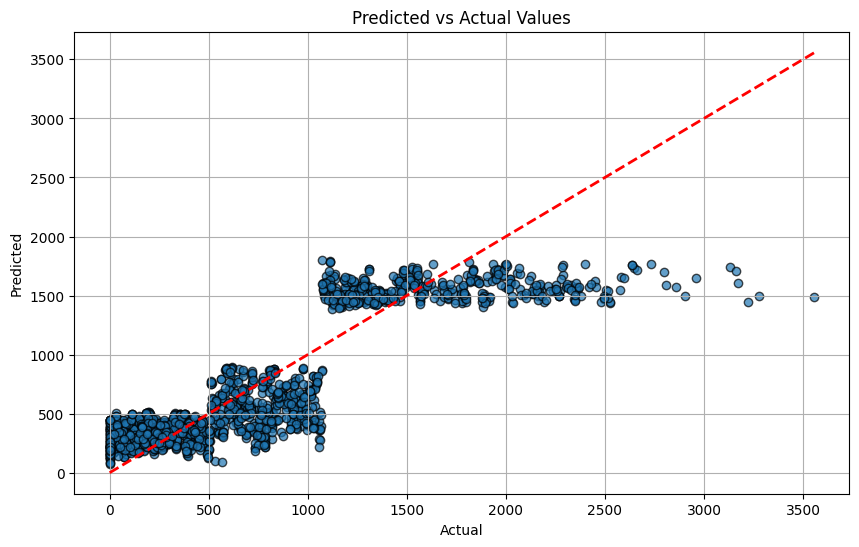

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Define a function to evaluate the best individual
def evaluate_best_individual(best_individual, X_test, y_test):
    # Compile the individual to a callable function
    func = toolbox.compile(expr=best_individual)

    # Apply the function to the test data
    predictions = np.array([func(*row) for row in X_test])

    # Calculate the fitness (MSE) on the test set
    mse = mean_squared_error(y_test, predictions)

    # Calculate the R² score on the test set
    r2 = r2_score(y_test, predictions)

    # Print the results
    print(f"Test MSE: {mse}")
    print(f"Test R² Score: {r2}")

    # Plot the predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, edgecolor='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual Values')
    plt.grid(True)
    plt.show()

    return mse, r2

# Ensure X_test and y_test are numpy arrays for compatibility
X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluate the best individual on the test set
mse, r2 = evaluate_best_individual(bestind, X_test, y_test)


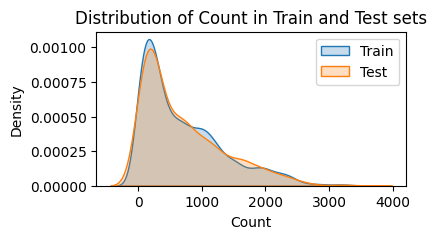



---

Our evolved individual achieved a TEST MSE of 101,346 which is slightly higher comapred to our TRAIN MSE of 98,169. This results in a generalization gap of 3177 which is an imporvement over 26,588 before. The R2 value also has a significant improvement from 0.3 to 0.765.

There is generally less concentration along the Y axis and the Y axis variance has impproves. THe data also mimics the distribution of the Test distribution better. This further explain the tendency for the data to be split into the 2 clusters.


---

We plot our tree after the code below. It is more complex and larger in size but retains the mul(x11, x16) solution from the previous solution. Setting the parsimony lower did lead to a better solution however, it lead to a possibly more bloated solution. There is a level of non linearity achieved through the use of more muliplication operationsin conjunction with additions and extra features and even some ephemeral constants. It is our best evolved tree.

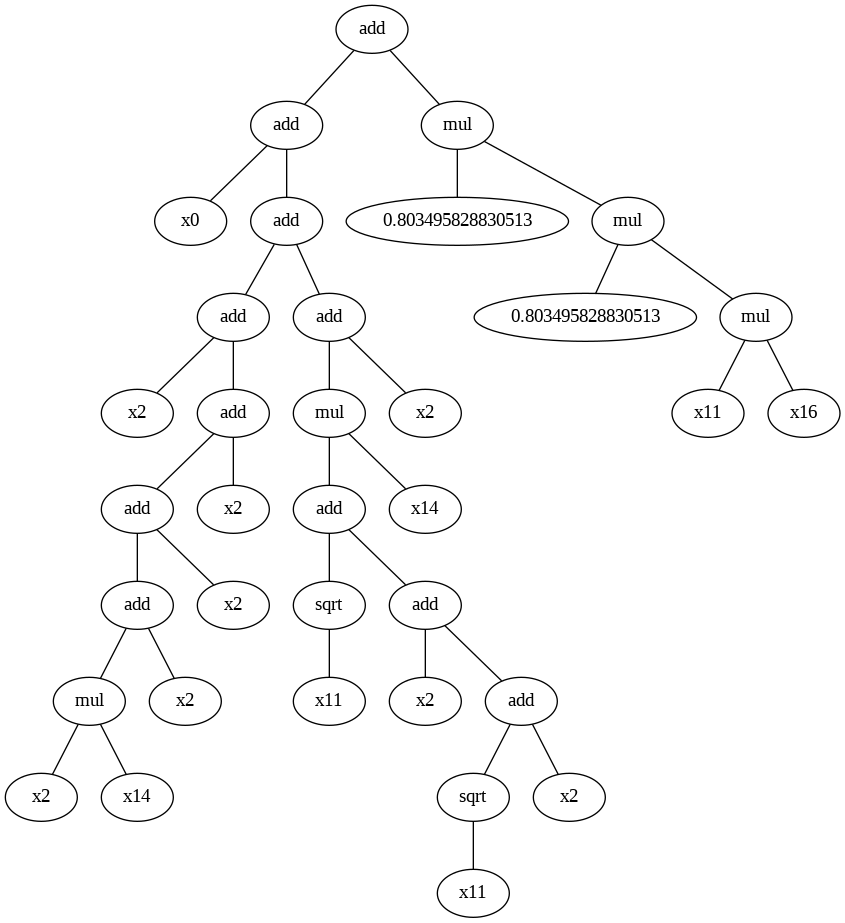

In [ ]:

nodes, edges, labels = gp.graph(best_ind)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]
treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

51


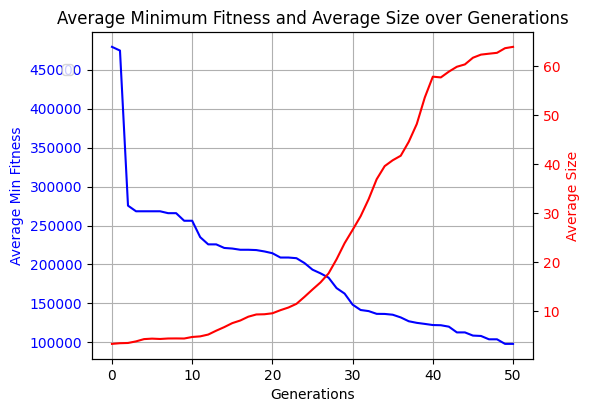

In [ ]:
#DATA WAS LOST SO HAD TO MANUALLY COLLATE INTO LISTS. THE NEXT CODE BLOCK SHOULD ALLOW A RERUN. ONLY INLCLUDED 2 RUNS, NOT 3 AS COLLAB KEPT TIMING OUT
import matplotlib.pyplot as plt
import numpy as np
min_fitness1 = [
    280018, 270483, 270483, 256074, 256074, 256074, 256074, 256074, 256074, 256074,
    256074, 213959, 212210, 212210, 212210, 212210, 212210, 212210, 212210, 212210,
    212210, 212210, 212210, 212210, 212210, 211581, 211581, 211581, 185802, 185312,
    166396, 155815, 155606, 151229, 151133, 150920, 149149, 140344, 140344, 137626,
    134936, 134269, 130574, 127590, 127590, 119434, 118475, 109890, 109890, 98169.8,
    98169.8
]

avg_size1 = [
    3.232, 3.324, 3.432, 4.158, 4.816, 5.134, 5.368, 5.484, 5.486, 5.452, 5.49, 5.36,
    5.506, 5.698, 6.084, 7.102, 7.148, 7.074, 7.052, 7.016, 7.026, 6.956, 7.104, 7.134,
    7.128, 7.0, 6.968, 7.256, 7.798, 9.202, 9.744, 9.64, 10.618, 13.008, 15.324, 16.648,
    17.952, 19.514, 21.046, 20.864, 20.402, 20.098, 22.466, 24.464, 25.426, 28.154,
    29.426, 29.806, 30.16, 32.054, 32.606
]

min_fitness2 = [
    678294, 678294, 280422, 280422, 280422, 280422, 280422, 275559, 275559, 256121,
    256121, 256121, 239394, 239335, 230207, 228689, 225555, 225555, 224746, 221273,
    216693, 205625, 205625, 203925, 191475, 175129, 165689, 154700, 153614, 140051,
    130604, 127423, 124790, 122132, 121997, 120198, 115040, 114023, 109925, 109925,
    109721, 109890, 109890, 98169.8, 98169.8, 98169.8, 98169.8, 98169.8, 98169.8, 98169.8, 98169.8
]

avg_size2 = [
    3.19, 3.368, 3.356, 3.282, 3.556, 3.434, 3.056, 3.138, 3.16, 3.16,
    3.752, 4.132, 4.728, 6.126, 7.196, 7.812, 8.84, 10.474, 11.406, 11.526,
    11.914, 13.25, 14.196, 15.672, 18.534, 21.672, 24.614, 27.998, 33.242, 38.414,
    43.32, 49.022, 55.04, 60.8, 63.848, 64.918, 65.466, 69.614, 75.36, 86.398,
    95.372, 95.372, 95.372, 95.372, 95.372, 95.372, 95.372, 95.372, 95.372, 95.372, 95.372
]

generations = list(range(51))
print(len(avg_size2))

# Calculate the average of the three lists
average_min_fitness = np.mean([min_fitness2, min_fitness1], axis=0)
average_size = np.mean([avg_size2, avg_size1], axis=0)

fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the average minimum fitness
ax1.set_xlabel('Generations')
ax1.set_ylabel('Average Min Fitness', color='blue')
ax1.plot(generations, average_min_fitness, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for the average size
ax2 = ax1.twinx()
ax2.set_ylabel('Average Size', color='red')
ax2.plot(generations, average_size, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.title('Average Minimum Fitness and Average Size over Generations')
plt.show()

Upon closer inspection from our 2 runs htat were savable, we see our solution goes beyond the local minima of 200,000s. This allows us to achieve solutions of MSE of 100,000 and below - acheiving the best TEST MSE of 101,346 which achieves an R2 score of 0.765. This is a satisfactory result however it was achieved by encountering a level of bloat.

The figure above from the 2 runs show the average size increase significantly in order to find solutions. This shows us that the parsimony size by itself cannot help eleviate bloat and a more sophisticated solution such as penalising the fitness function with bloat or ideally a multiobjective evolutionary appproach could be used since the MSE score and size have a contradicting relationship.

Additionally, the use of shrink mutation could be introduced to also reduce some tree branches randomly to tackle the bloat.

Overall, we manages to obtain a good regression model with a low population and generation size so computationally it is also efficient. Due to technical limitations though we were unable to test our solution beyond jsut 2 runs. From the looks of the plot above it seems that the fitness continues to decrease for further generations instead of plateauing which is a good sign of good convergence as well.


---

DATA FROM THE CODE BELOW WAS USED TO MANUALLY CREATE THE LISTS FROM THE PLOT ABOVE. RERUN IF NEEDED

In [ ]:
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms

# Function to perform multiple runs and collect logbooks and final populations
def multiple_runs_test3(toolbox, n_runs, cxpb, mutpb, ngen, pop_size, parsimony_size):
    all_logbooks = []
    final_populations = []
    best_individuals = []

    for run in range(n_runs):
        random.seed(run)  # Set the random seed for reproducibility
        np.random.seed(run)
        population = toolbox.population(n=pop_size)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        size_stats = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats, size=size_stats)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "nevals"] + mstats.fields

        toolbox.register("select", tools.selDoubleTournament, fitness_size=10, parsimony_size=parsimony_size, fitness_first=True)

        population, logbook = algorithms.eaSimple(
            population, toolbox, cxpb=cxpb, mutpb=mutpb,
            ngen=ngen, stats=mstats, halloffame=hof, verbose=True
        )

        all_logbooks.append(logbook)
        final_populations.append(population)
        best_individuals.append(hof[0])

    return all_logbooks, final_populations, best_individuals

# Define the parameters
n_runs = 3  # Reduced to 3 runs to save computation time
ngen = 50
pop_sizes = [500]
cxpb = 0.5  # Constant value for crossover probability
mutpb = 0.2  # Constant value for mutation probability
parsimony_size = 1.2  # Range of parsimony sizes to test

# Perform runs for different population sizes
grid_search_results_test3 = {}
final_populations_results_test3 = {}
best_individuals_results_test3 = {}

for pop in pop_sizes:
    key = f"pop_{pop}"
    print(f"Running with pop size: {pop}")
    logbooks3, final_populations3, best_individuals3 = multiple_runs_test3(toolbox, n_runs, cxpb, mutpb, ngen, pop, parsimony_size)
    grid_search_results_test3[key] = logbooks3
    final_populations_results_test3[key] = final_populations3
    best_individuals_results_test3[key] = best_individuals3


